# HOMEWORK PART 1

---

1. Develop a DMD model to forecast the future population states.
2. Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables.
3. Empirical Predator-Prey models such as Lotka-Volterra are commonly used to models such phenomenon. Consider the model x ̇ = (b − py)x and y ̇ = (rx − d)y. Use the data to fit values of b, p, r and d.
4. Find the best fit nonlinear, dynamical systems model to the data using sparse regression.


In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from scipy.linalg import hankel
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from scipy import integrate

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']}) # Palatino font
plt.rcParams['pdf.fonttype'] = 42

Generarte the required data for snowshow hare and Canadian Linx. Data is collected every two years so interpolation for data augmentation required.

In [2]:
data_dict = {'Year': [], 'Snowshow Hare': [], 'Canada Lynx': []}
dt = 2
years = np.arange(1845, 1903 + dt, dt)
time = np.arange(0, 1903 - 1845 + dt, dt)
SH = np.array([20, 20, 52, 83, 64, 68, 83, 12, 36, 150, 110, 60, 7, 10, 70,
               100, 92, 70, 10, 11, 137, 137, 18, 22, 52, 83, 18, 10, 9, 65])
CL = np.array([32, 50, 12, 10, 13, 36, 15, 12, 6, 6, 65, 70, 40, 9, 20, 
               34, 45, 40, 15, 15, 60, 80, 26, 18, 37, 50, 35, 12, 12, 25])

data_dict['Years'] = years
data_dict['Snowshow Hare'] = SH
data_dict['Canada Lynx'] = CL

In [3]:
def DMD(X, dX, r, time):
    """Apply Dynamic Mode Decomposition (DMD)
    
        Parameters
    ----------
    X : array
        State matrix size: features x time.
    dX : array
        Time shifted state matrix.
    time : array
        Time steps.
    r : int
        Rank truncation.

    Returns
    -------
    U, V, S : array
        Singular Value Decomposition (SVD) of X.
    x_dmd : array
        DMD reconstruction.
    
    """
    dt = time[1] - time[0]
    
    # SVD on the state matrix
    U, S, Vh = np.linalg.svd(X, full_matrices=False)
    V = Vh.conj().T
    U = U[:, :r]
    V = V[:, :r]
    S = S[:r]
    
    # Projection of state matrix onto U
    A_tilde = U.conj().T @ dX @ V @ np.linalg.inv(np.diag(S))
    
    # Eigenvalues
    Lambda, W = np.linalg.eig(A_tilde)
    
    # Eigenvectors
    Phi = dX @ V @ np.linalg.inv(np.diag(S)) @ W
    
    
    X0 = X[:, 0] # initial conditions

    omega = np.log(Lambda) / dt

    b = np.linalg.pinv(Phi) @ X0


    # Reconstruction
    x_dmd = np.zeros((r, len(time)), dtype=omega.dtype)
    for k in range(len(time)):
        x_dmd[:, k] = b * np.exp(omega * time[k])
    x_dmd = np.dot(Phi, x_dmd)
    
    #x_k = np.zeros((r, len(t_new)), dtype=omega.dtype)
    #for k in range(len(t_new)):
    #    x_k[:, k] = Phi @ (np.diag(Lambda) ** (k)) @ b
    
    return U, S, V, x_dmd   

## Part 1: Develop a DMD model to forecast the future population states.

Interpolation causes the value of the populations for some _t_ to have a value lower than zero. Modify all values $\leq 1$ to $1$.

In [4]:
f_SH = interp1d(time, SH, kind='cubic')
f_CL = interp1d(time, CL, kind='cubic')

dt_new = 0.1
years_new = np.arange(1845, 1903 + dt_new, dt_new)
t_new = np.arange(0, 1903 - 1845 + dt_new, dt_new)
SH_new = f_SH(t_new)
tmp = SH_new <= 1
SH_new[tmp] = 1
CL_new = f_CL(t_new)
tmp = CL_new <= 1
CL_new[tmp] = 1

<IPython.core.display.Javascript object>


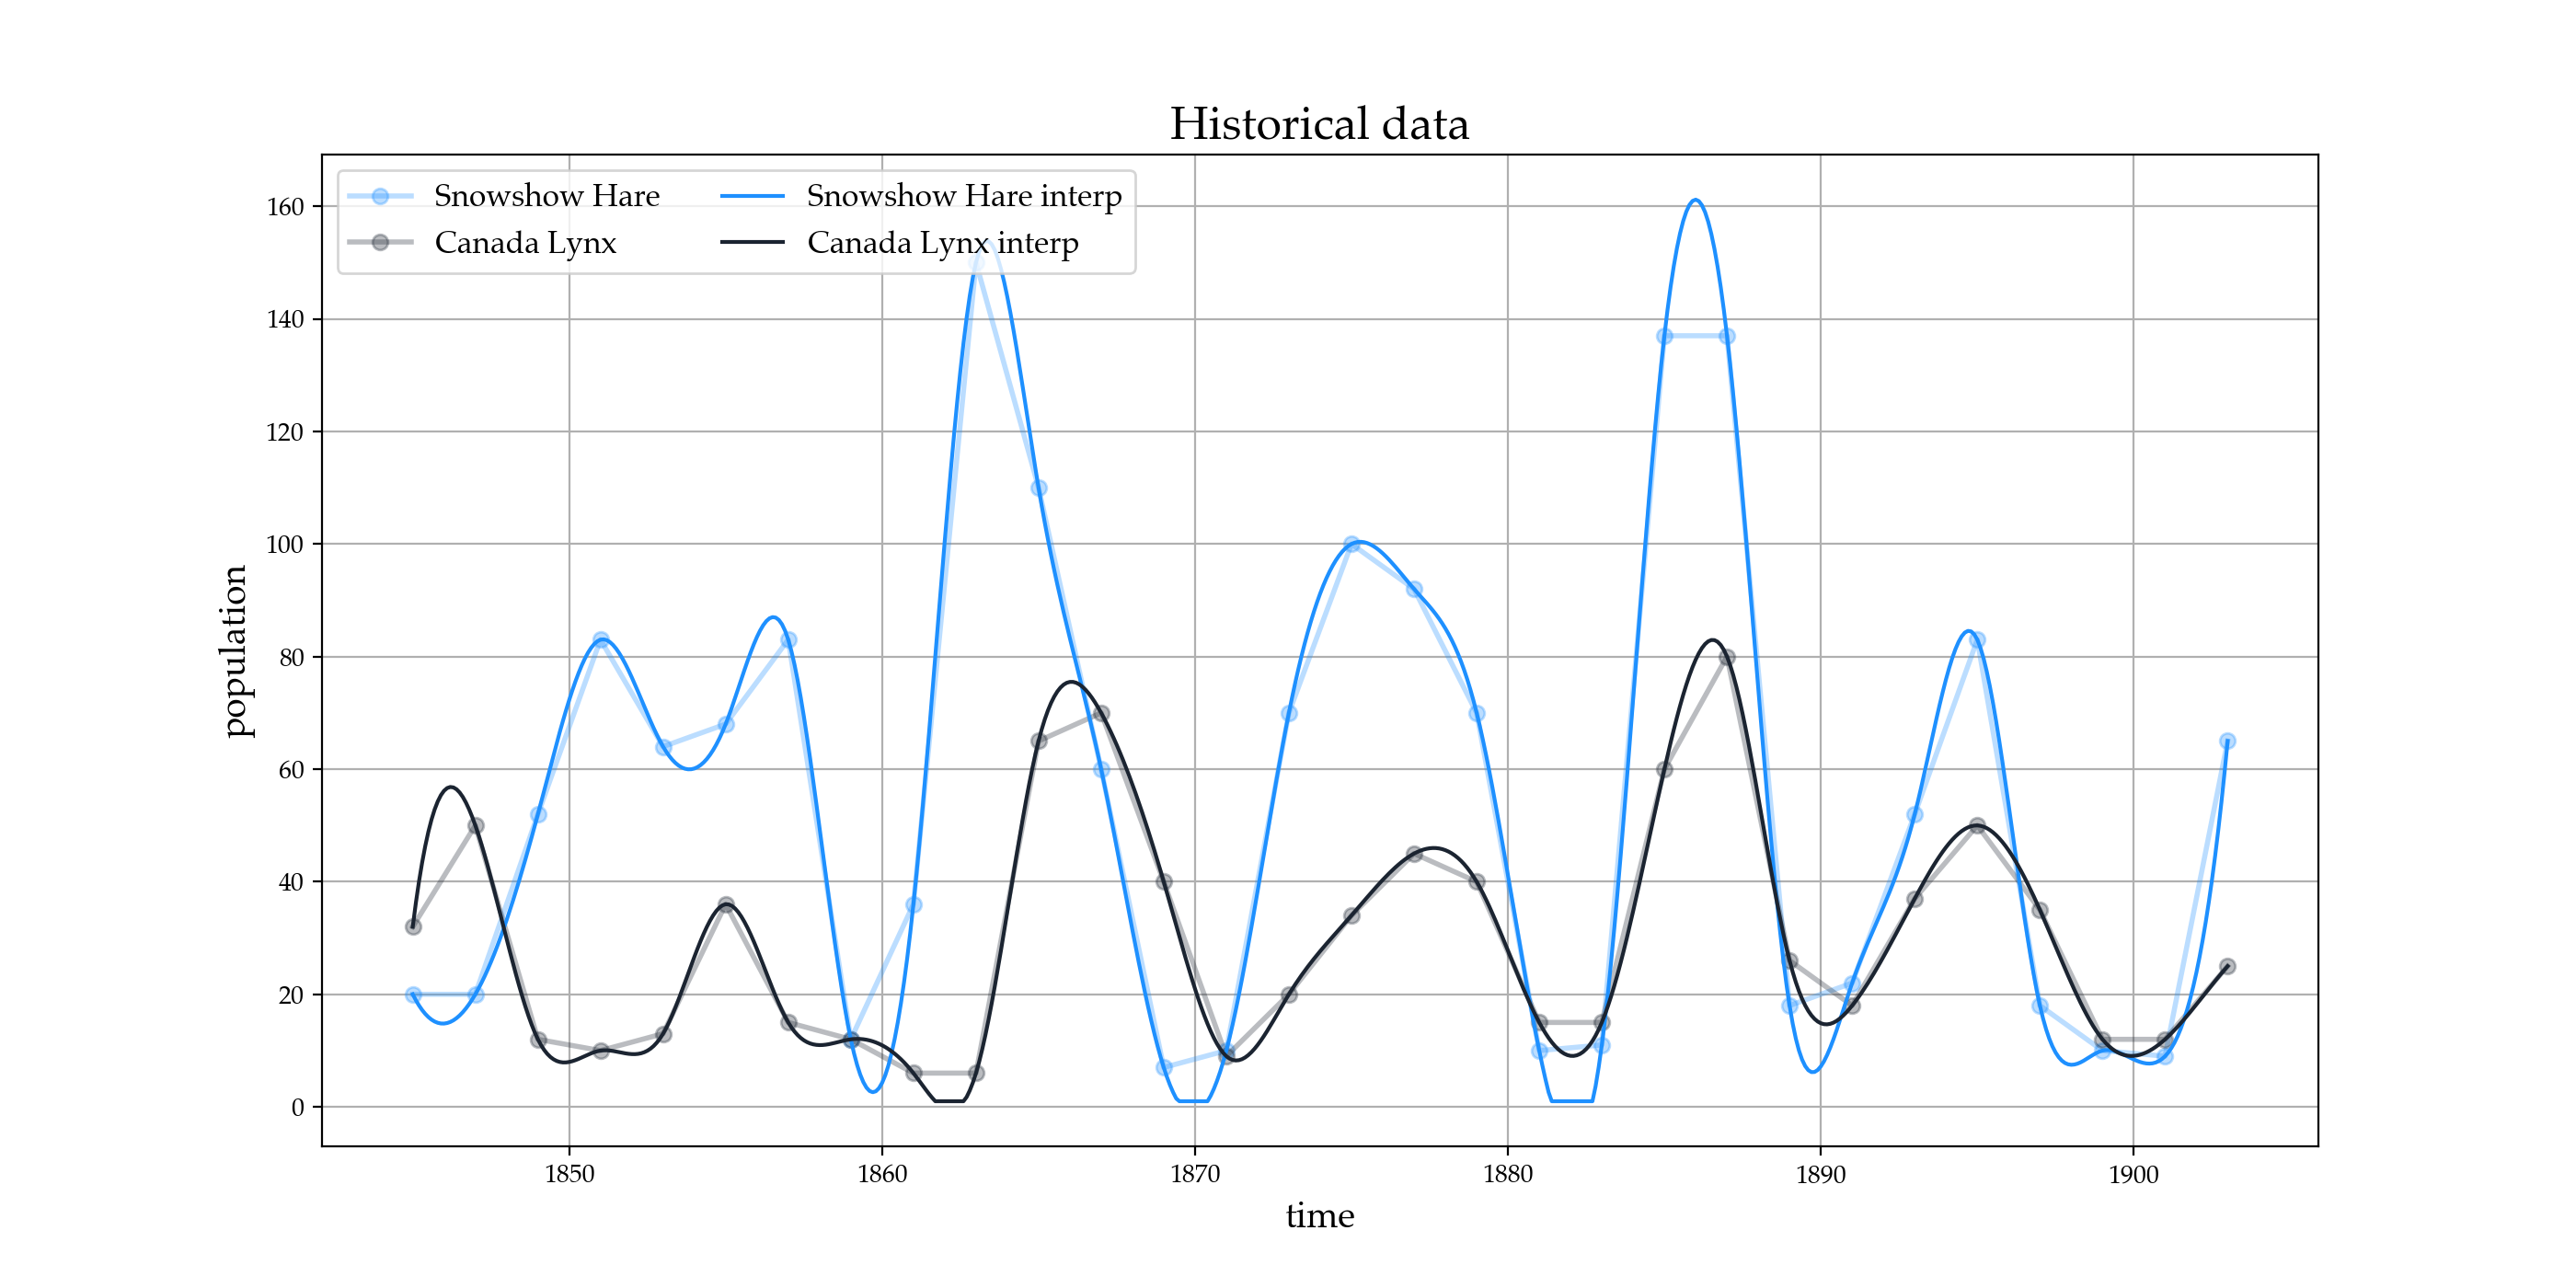

In [5]:
fig = plt.figure(figsize=(14, 7))
plt.plot(years, SH, '-o', linewidth='2', color='dodgerblue', alpha=.3)
plt.plot(years, CL, '-o', linewidth='2', color='xkcd:dark', alpha=.3)
plt.plot(years_new, SH_new, color='dodgerblue')
plt.plot(years_new, CL_new, color='xkcd:dark')
plt.title('Historical data', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx', 'Snowshow Hare interp', 'Canada Lynx interp'], fontsize = 12, ncol=2)
plt.grid(True, which="both")
fig.savefig('figures/population_data.pdf', format='pdf', dpi=1200)

Stack the population history of the two species into a $2 \times n_{times}$ array. From this array we generate the on-time shifted $dX$ which will be the target of the regression. Split data into train and test.

In [6]:
data = np.vstack((SH, CL))
X = data[:, :-1]
dX = data[:, 1:]

n_test = int(X.shape[1] * 0.2)

# Train and test
X_train = X[:, :-n_test]
dX_train = dX[:, :-n_test]
X_test = X[:, -n_test:]
dX_test = dX[:, -n_test:]

In [13]:
print('- - - - -')
print('Data sets dimension:')
print('- - - - -')
print("Size of train matrix X_train: {}x{} ".format(X_train.shape[0], X_train.shape[1]))
print("Size of test matrix X_test: {}x{} ".format(X_test.shape[0], X_test.shape[1]))
print('- - - - -')

- - - - -
Data sets dimension:
- - - - -
Size of train matrix X_train: 2x24 
Size of test matrix X_test: 2x5 
- - - - -


In [14]:
# Full SVD:
U, S, V = np.linalg.svd(X_train, full_matrices=True)
print('- - - - -')
print('Full SVD')
print('- - - - -')
print("Size of matrix U: {}x{} ".format(U.shape[0], U.shape[1]))
print("Size of matrix V: {}x{} ".format(V.shape[0], V.shape[1]))
print('- - - - -')

- - - - -
Full SVD
- - - - -
Size of matrix U: 2x2 
Size of matrix V: 24x24 
- - - - -


In [15]:
# Economy SVD
r = 2
U, S, V = np.linalg.svd(X_train, full_matrices=False)
U = U[:, :r]
V = V[:r, :]
V = V.T # np.linalg gives the cognugate transpose
S = S[:r]
print('- - - - -')
print('Economy SVD:')
print('- - - - -')
print("Size of matrix U: {}x{} ".format(U.shape[0], U.shape[1]))
print("Size of matrix V: {}x{} ".format(V.shape[0], V.shape[1]))
print('- - - - -')

- - - - -
Economy SVD:
- - - - -
Size of matrix U: 2x2 
Size of matrix V: 24x2 
- - - - -


<IPython.core.display.Javascript object>


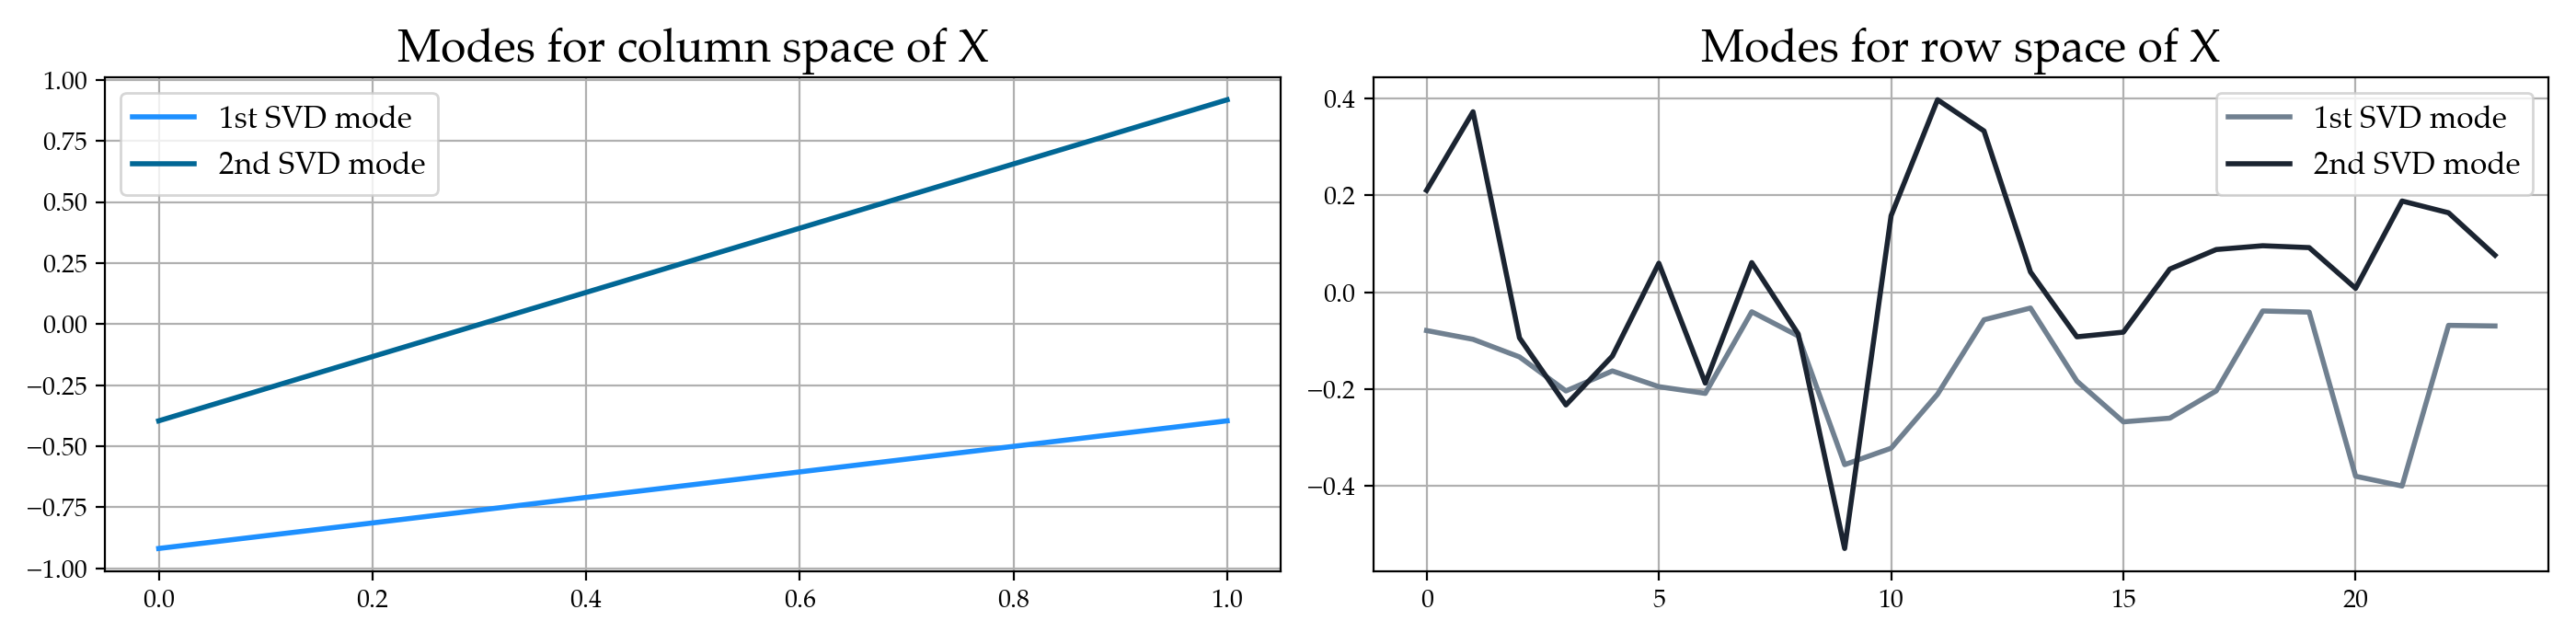

In [16]:
fig = plt.figure(figsize=(14, 3.5))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(np.real(U[:, 0]), linewidth='2', color='dodgerblue')
h = ax.plot(np.real(U[:, 1]), linewidth='2', color='xkcd:peacock blue')
ax.set_title('Modes for column space of X', fontsize = 18)
ax.legend(['1st SVD mode', '2nd SVD mode'], fontsize = 12)
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(np.real(V[:, 0]), linewidth='2', color='slategray')
h = ax.plot(np.real(V[:, 1]), linewidth='2', color='xkcd:dark')
ax.set_title('Modes for row space of X', fontsize = 18)
ax.legend(['1st SVD mode', '2nd SVD mode'], fontsize = 12)

gs.tight_layout(fig)

ax.grid()

<IPython.core.display.Javascript object>


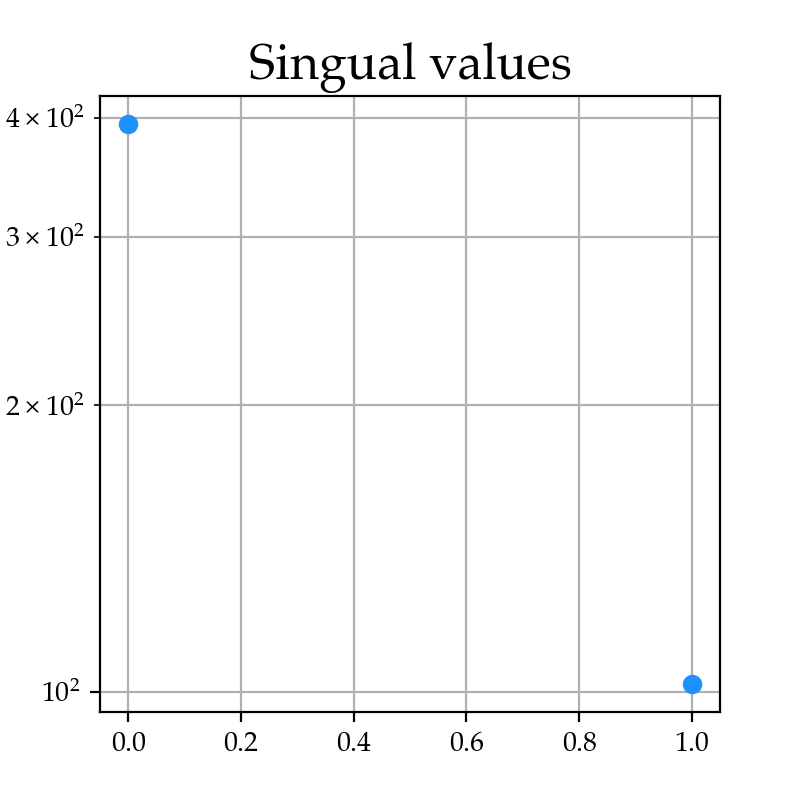

In [17]:
fig = plt.figure(figsize=(4, 4))
plt.plot(range(len(S)), S, 'o', linewidth='2', color='dodgerblue')
plt.yscale('log')
plt.title('Singual values', fontsize = 18)
plt.grid(True, which="both")

Let's apply DMD

In [18]:
U, S, V, x_dmd = DMD(X, dX, r, time)

<IPython.core.display.Javascript object>


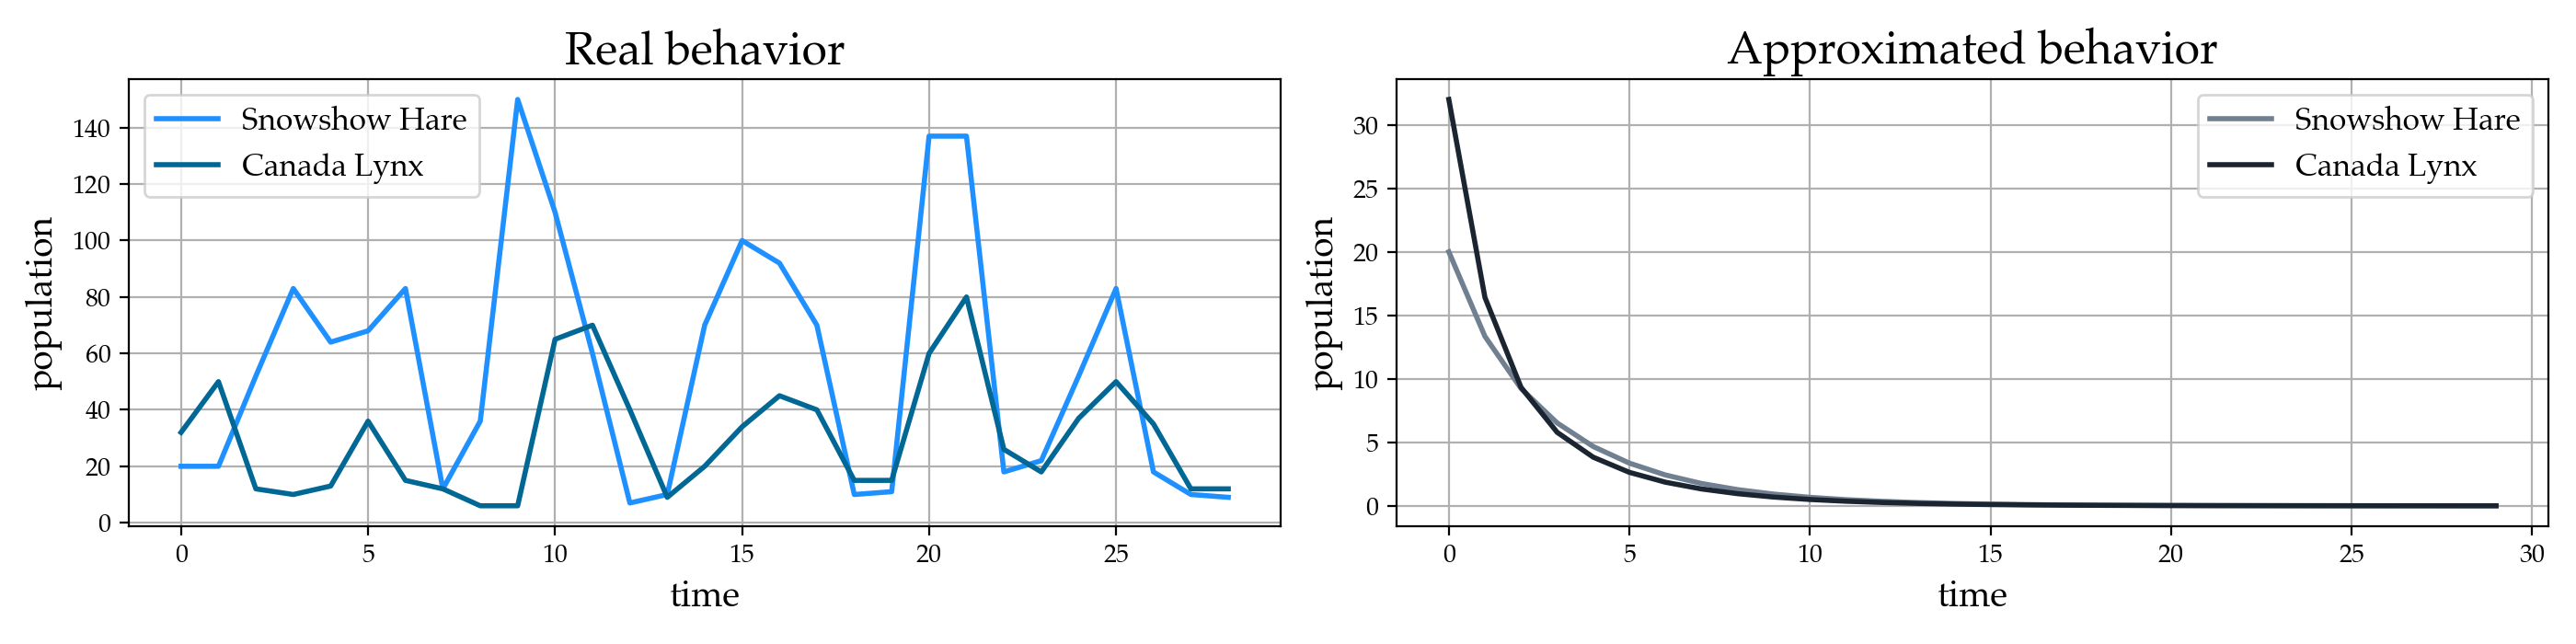

In [19]:
fig = plt.figure(figsize=(14, 3.5))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.2, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(X[0, :], linewidth='2', color='dodgerblue')
h = ax.plot(X[1, :], linewidth='2', color='xkcd:peacock blue')
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12)
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(np.real(x_dmd[0, :]), linewidth='2', color='slategray')
h = ax.plot(np.real(x_dmd[1, :]), linewidth='2', color='xkcd:dark')
ax.set_title('Approximated behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12)

gs.tight_layout(fig)

ax.grid()

Now we will repeat the same procedure but on the interpolated augmented dataset.

In [20]:
data = np.vstack((SH_new, CL_new))

X = data[:, :-1]
dX = data[:, 1:]

In [21]:
U, S, V, x_dmd = DMD(X, dX, r, t_new)

<IPython.core.display.Javascript object>


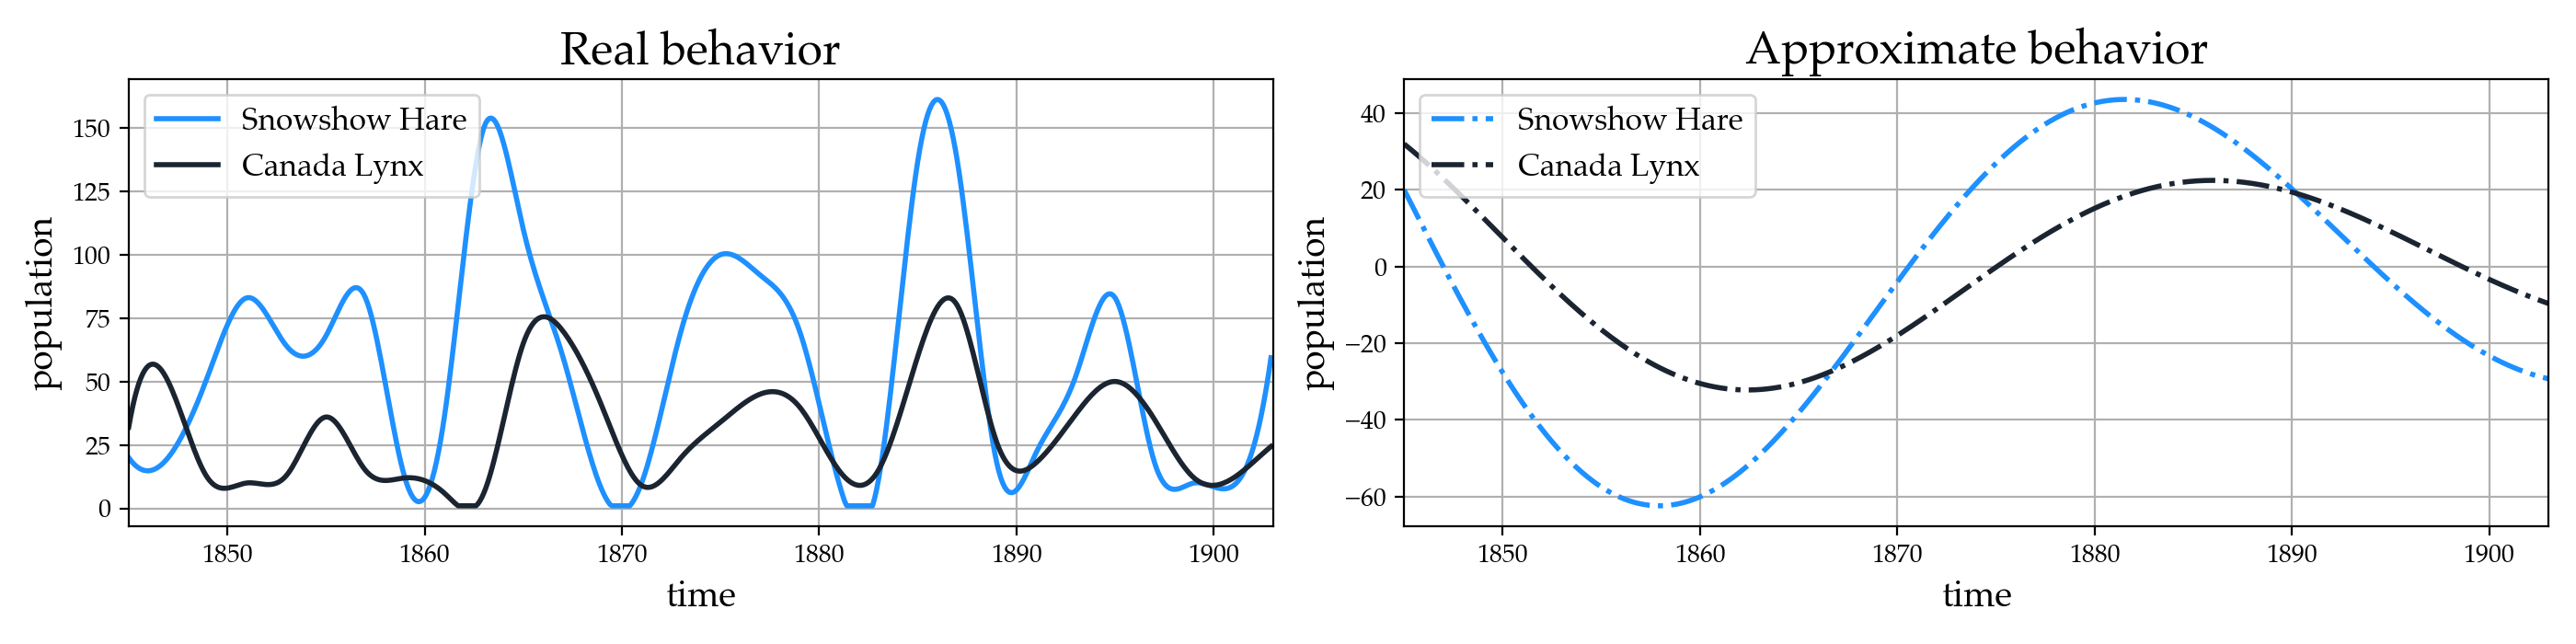

In [22]:
fig = plt.figure(figsize=(14, 3.5))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(years_new[:-1], X[0, :], linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:-1], X[1, :], linewidth='2', color='xkcd:dark')
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(years_new, np.real(x_dmd[0, :]), '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new, np.real(x_dmd[1, :]), '-.', linewidth='2', color='xkcd:dark')
ax.set_title('Approximate behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

gs.tight_layout(fig)

fig.savefig('figures/dmd.pdf', format='pdf', dpi=1200)

## Part 2: Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables.

We will try 4 different time-embeddings.

In [24]:
# Final time of training point
t_start = 400

# Required for plot
t_window = t_start
x_train = np.ones((100,)) * years_new[t_start]
y_train = np.arange(0, 150, 150 / 100)

print('- - - - -')
print('Train / test split:')
print('- - - - -')
print("We have a total of {} time samples".format(data.shape[1]))
print("Training points are the first {}".format(t_start))
print('- - - - -')

- - - - -
Train / test split:
- - - - -
We have a total of 581 time samples
Training points are the first 400
- - - - -


In [25]:
n_emb = 5

H1 = data[:, :t_start]
dH1 = data[:, 1:t_start+1]
for i in range(1, n_emb):
    H1 = np.vstack((H1, data[:,i:t_start+i]))
    dH1 = np.vstack((dH1, data[:,i+1:t_start+i+1]))

In [26]:
n_emb = 50

H2 = data[:, :t_start]
dH2 = data[:, 1:t_start+1]
for i in range(1, n_emb):
    H2 = np.vstack((H2, data[:,i:t_start+i]))
    dH2 = np.vstack((dH2, data[:,i+1:t_start+i+1]))

In [27]:
n_emb = 100

H3 = data[:, :t_start]
dH3 = data[:, 1:t_start+1]
for i in range(1, n_emb):
    H3 = np.vstack((H3, data[:,i:t_start+i]))
    dH3 = np.vstack((dH3, data[:,i+1:t_start+i+1]))

In [28]:
H = hankel(data[:, :400])
Htmp = np.zeros_like(H)
Htmp[0::2, :] = H[:int(H.shape[0]/2),:]
Htmp[1::2, :] = H[int(H.shape[0]/2):,:]
H4 = Htmp[:, :-1]
dH4 = Htmp[:, 1:]

SVD of the four Hankel matrices in order to see the real rank of the system.

In [29]:
U1, S1, V1 = np.linalg.svd(H1, full_matrices=False)
V1 = V1.conj().T
U2, S2, V2 = np.linalg.svd(H2, full_matrices=False)
V2 = V2.conj().T
U3, S3, V3 = np.linalg.svd(H3, full_matrices=False)
V3 = V3.conj().T
U4, S4, V4 = np.linalg.svd(H4, full_matrices=False)
V4 = V4.conj().T

<IPython.core.display.Javascript object>


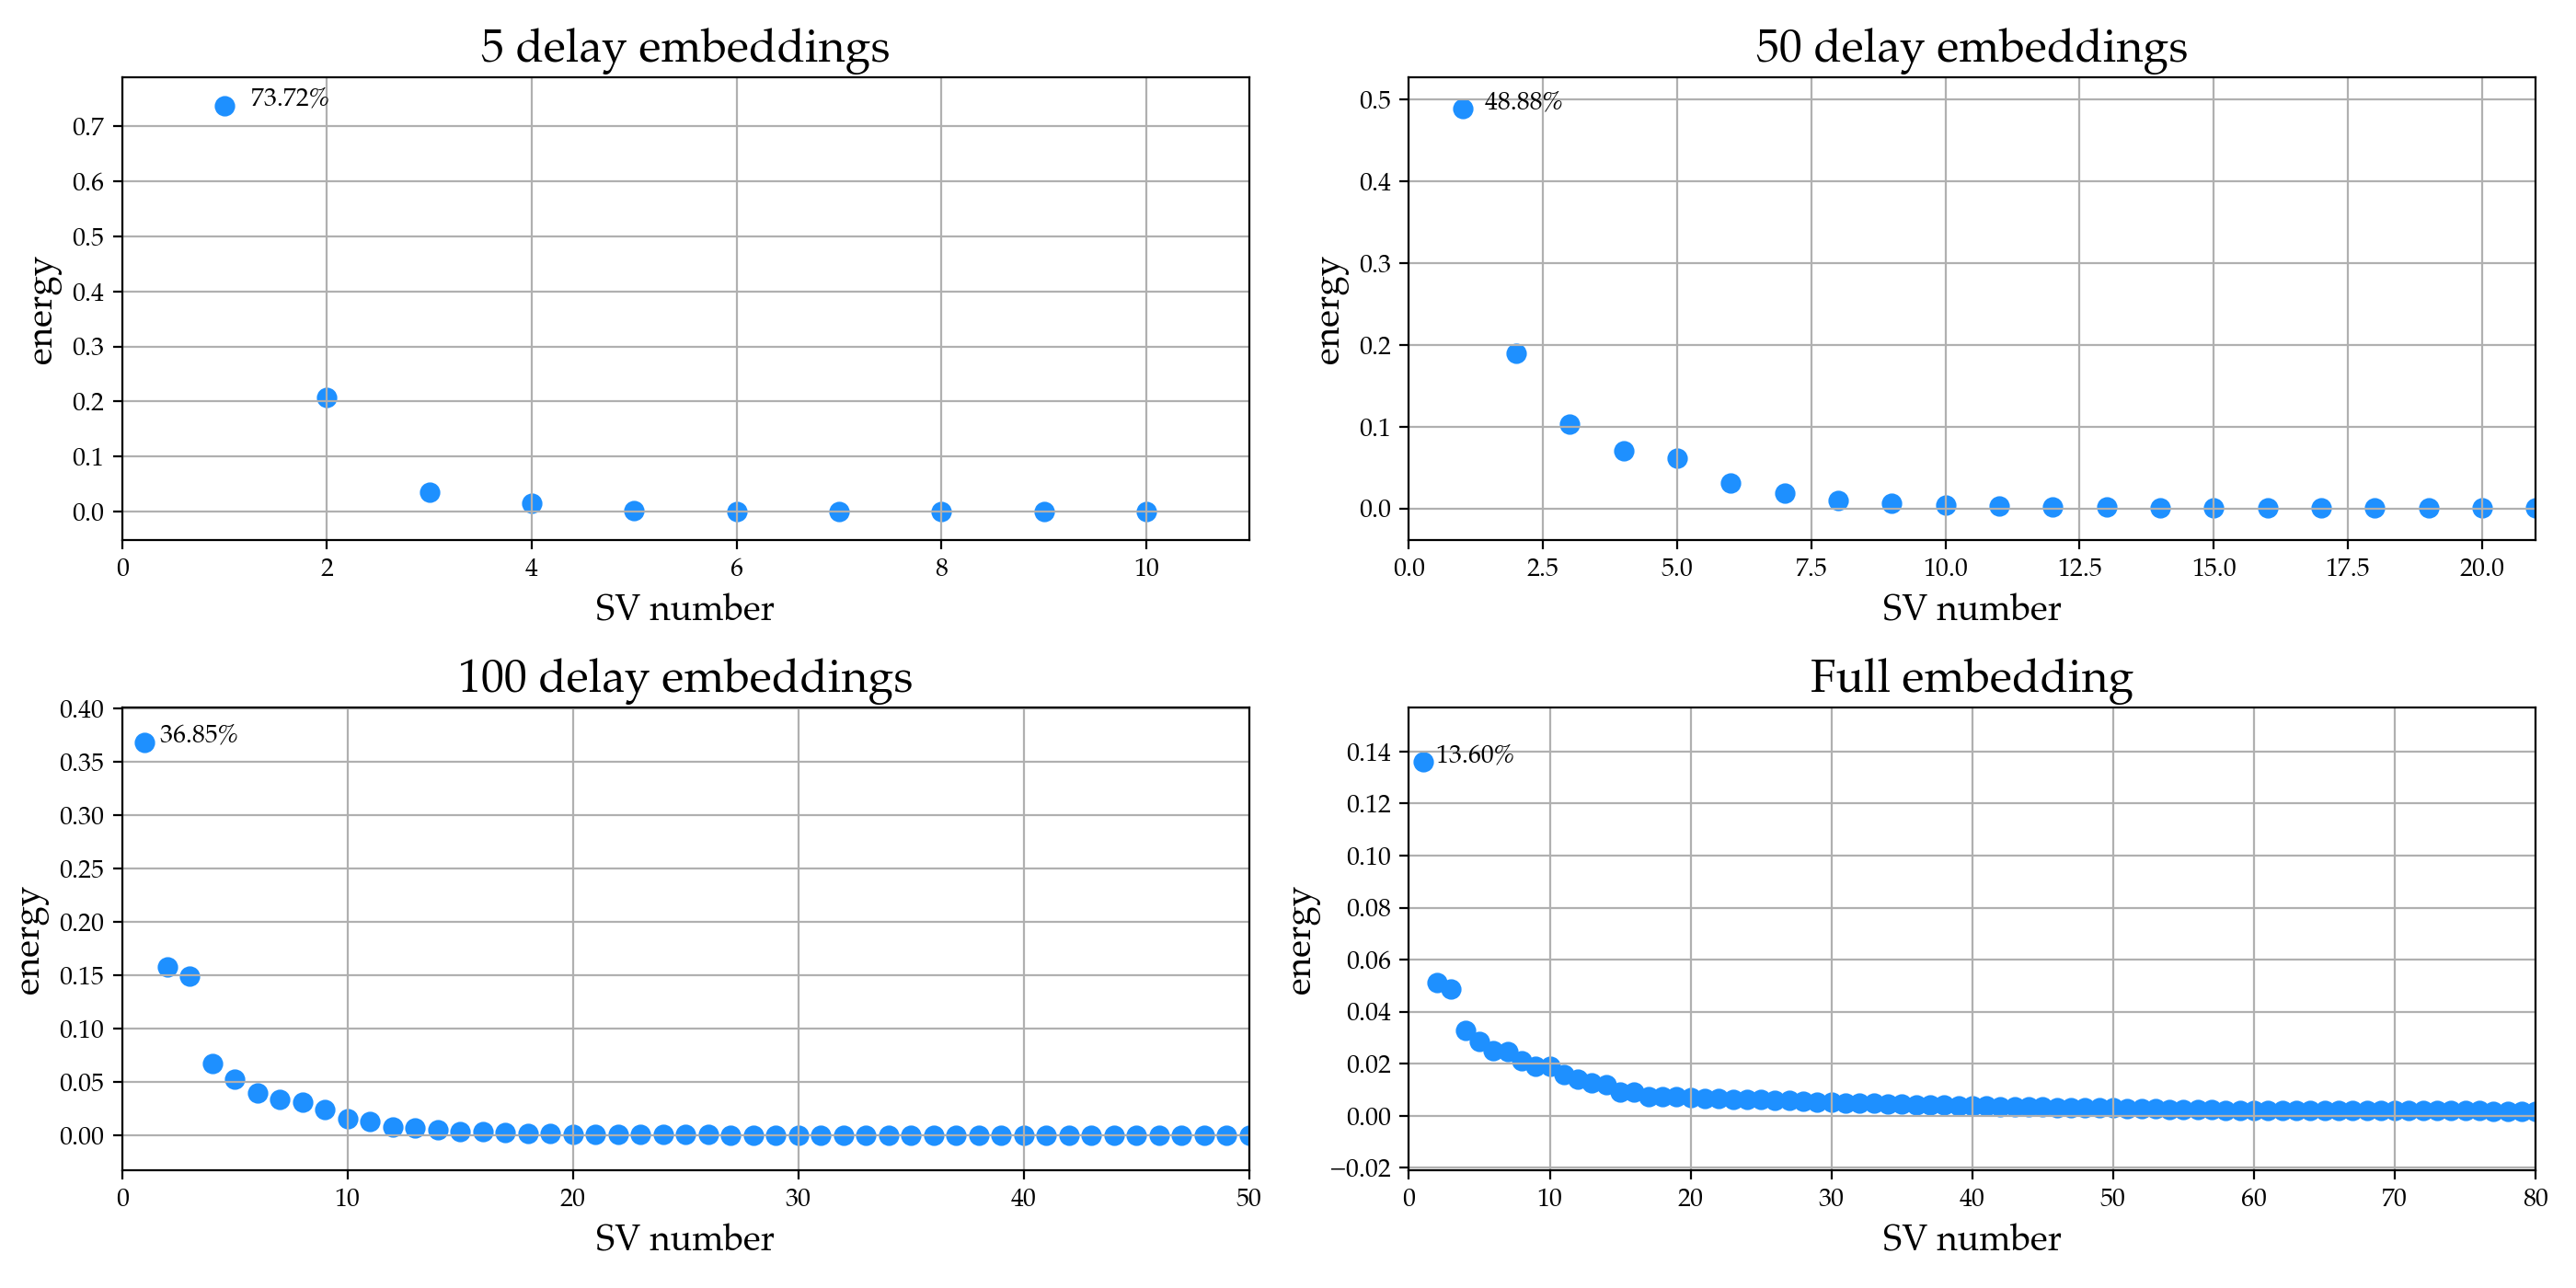

In [35]:
fig = plt.figure(figsize=(14, 7))

gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.4)

ax = plt.subplot(gs[0, 0])
h = ax.scatter(range(1, len(S1)+1), S1 / np.sum(S1), linewidth='2', color='dodgerblue')
ax.set_title('5 delay embeddings', fontsize = 18)
plt.text(1.2, S1[0] / np.sum(S1), '{:6.2f}'.format(S1[0] / np.sum(S1) * 100) + '%')
ax.set_xlim([0, 11])
plt.xlabel('SV number', fontsize = 14)
plt.ylabel('energy', fontsize = 14)
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.scatter(range(1, len(S2)+1), S2 / np.sum(S2), linewidth='2', color='dodgerblue')
ax.set_title('50 delay embeddings', fontsize = 18)
plt.text(1.3, S2[0] / np.sum(S2), '{:6.2f}'.format(S2[0] / np.sum(S2) * 100) + '%')
ax.set_xlim([0, 21])
plt.xlabel('SV number', fontsize = 14)
plt.ylabel('energy', fontsize = 14)
ax.grid()

ax = plt.subplot(gs[1, 0])
h = ax.scatter(range(1, len(S3)+1), S3 / np.sum(S3), linewidth='2', color='dodgerblue')
ax.set_title('100 delay embeddings', fontsize = 18)
plt.text(1.4, S3[0] / np.sum(S3), '{:6.2f}'.format(S3[0] / np.sum(S3) * 100) + '%')
ax.set_xlim([0, 50])
plt.xlabel('SV number', fontsize = 14)
plt.ylabel('energy', fontsize = 14)
ax.grid()

ax = plt.subplot(gs[1, 1])
h = ax.scatter(range(1, len(S4)+1), S4 / np.sum(S4), linewidth='2', color='dodgerblue')
ax.set_title('Full embedding', fontsize = 18)
plt.text(1.5, S4[0] / np.sum(S4), '{:6.2f}'.format(S4[0] / np.sum(S4) * 100) + '%')
ax.set_xlim([0, 80])
plt.xlabel('SV number', fontsize = 14)
plt.ylabel('energy', fontsize = 14)
ax.grid()

gs.tight_layout(fig)

fig.savefig('figures/td_energy.pdf', format='pdf', dpi=1200)

<IPython.core.display.Javascript object>


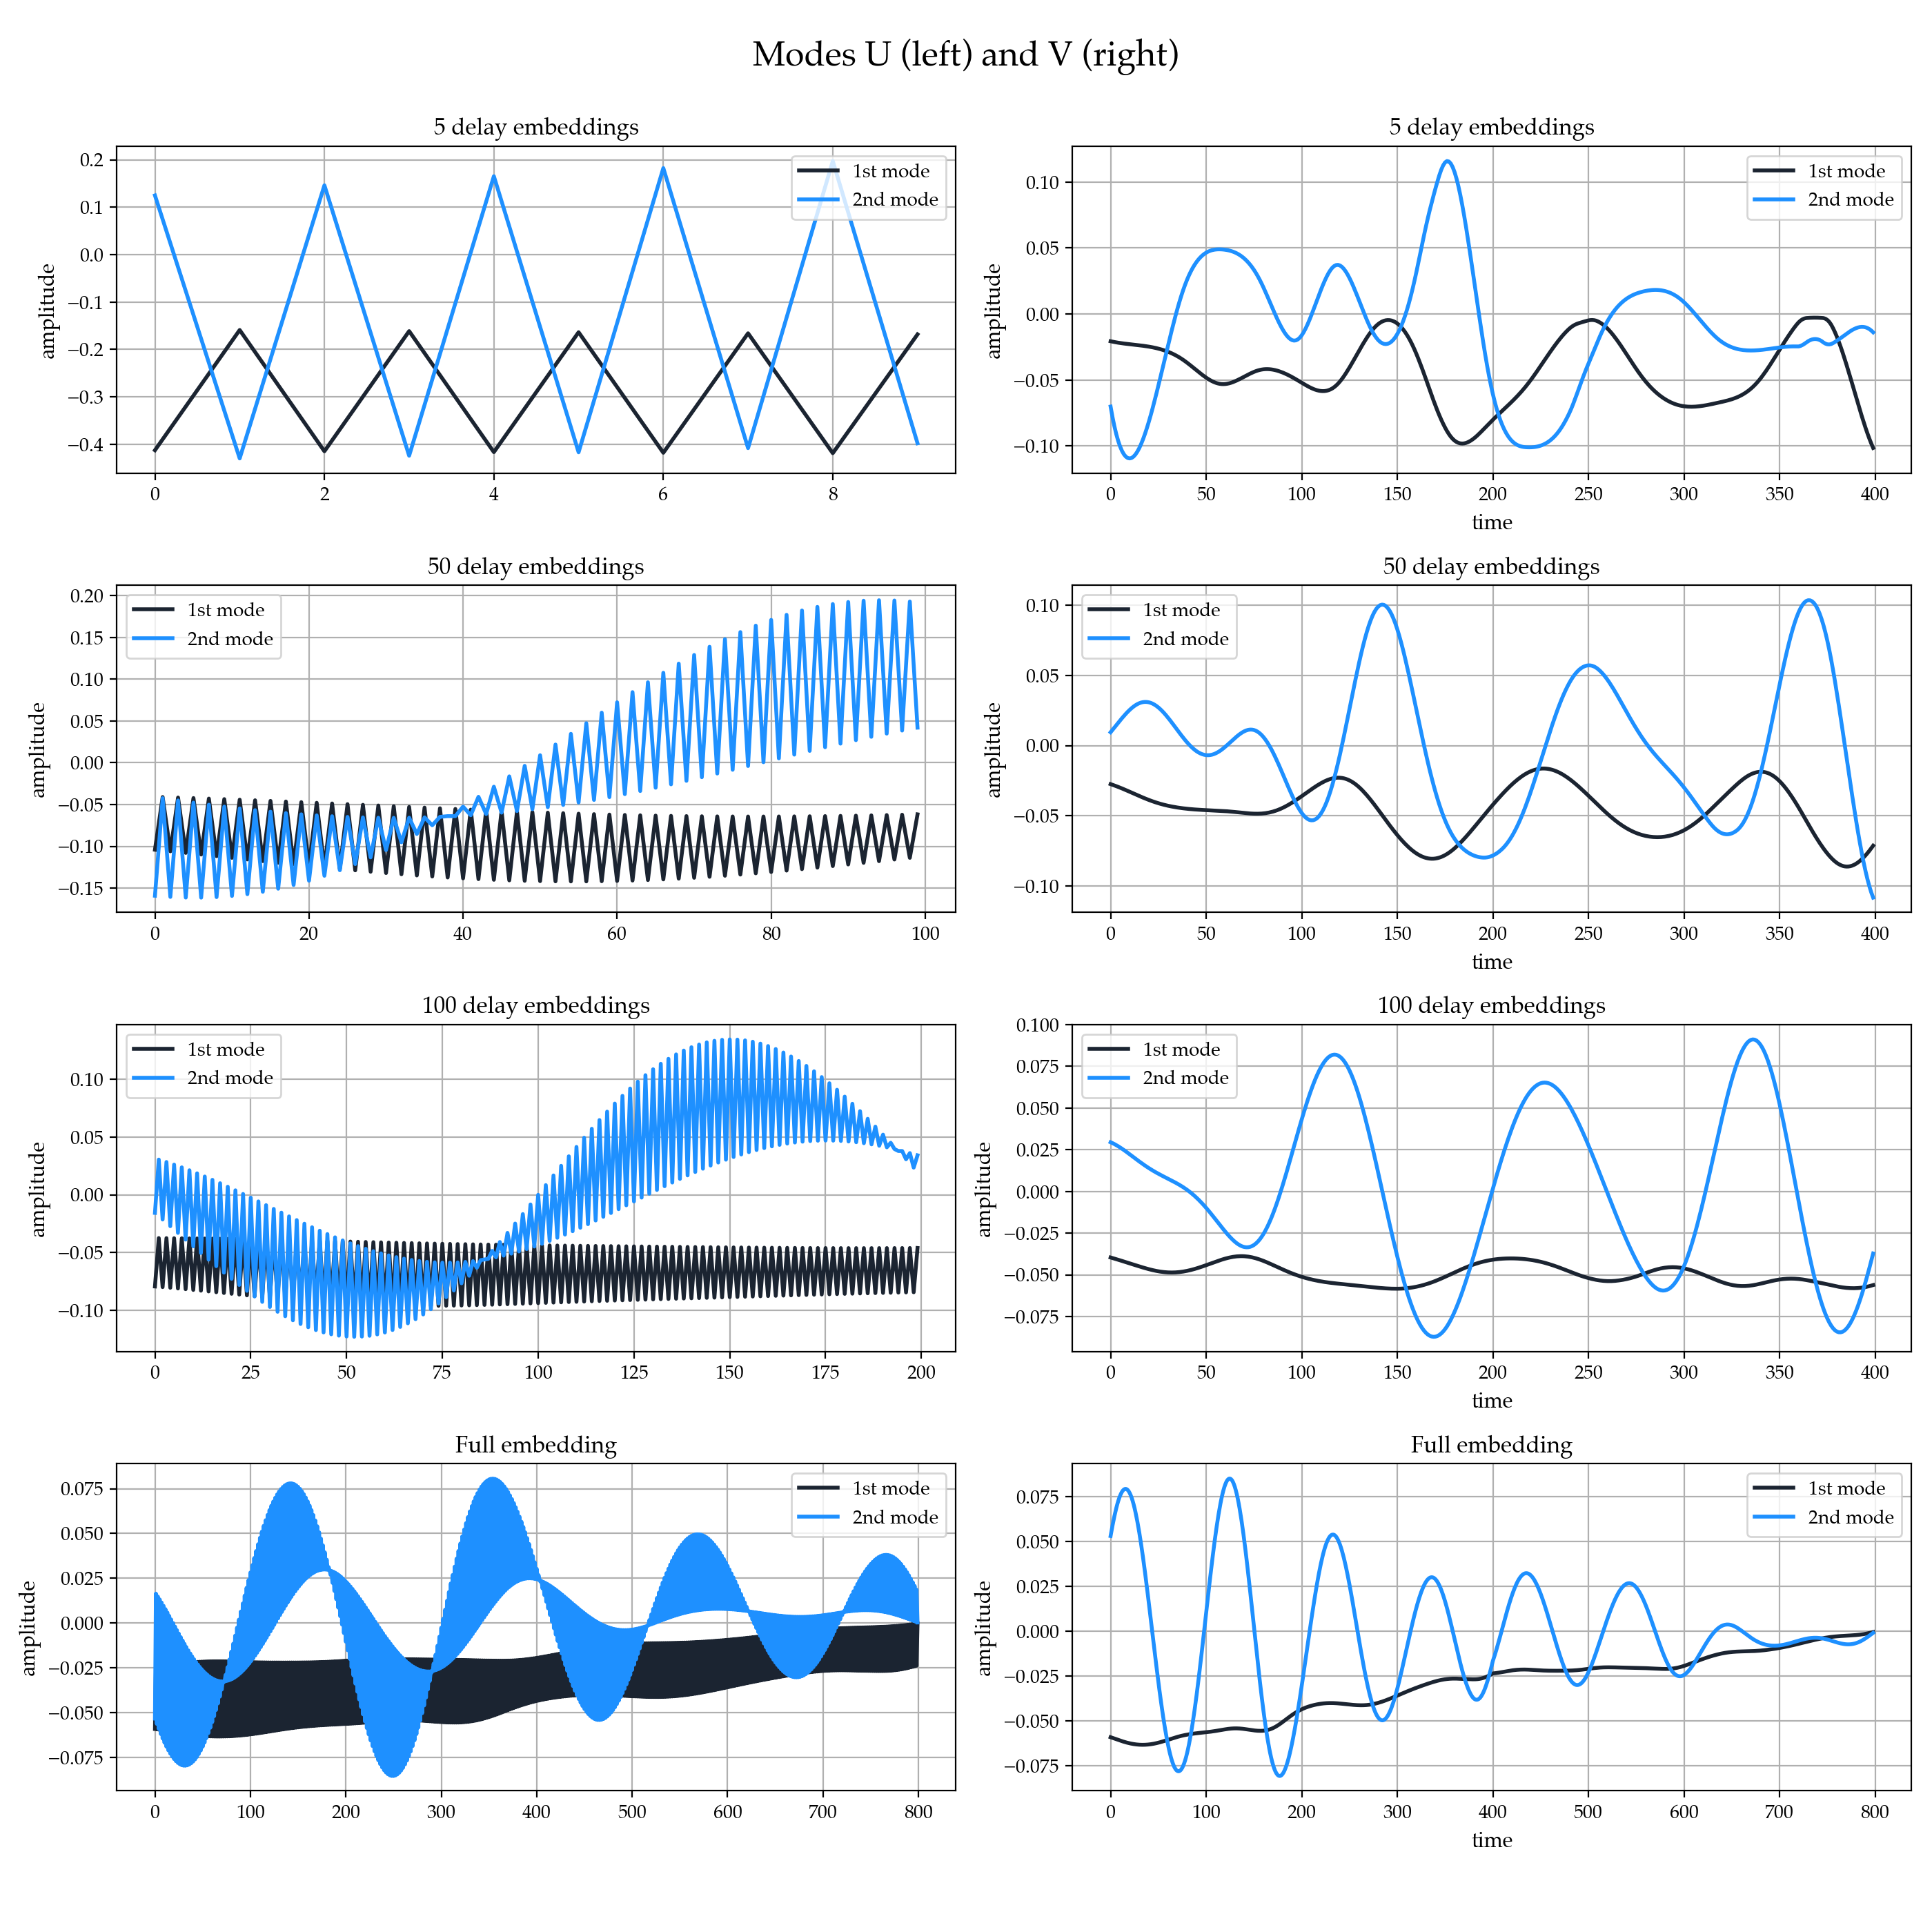

In [37]:
fig = plt.figure(figsize=(14, 14))
colors = ['xkcd:dark', 'dodgerblue', 'slategray']
gs = gridspec.GridSpec(4, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
fig.suptitle("Modes U (left) and V (right)", fontsize=18)

ax = plt.subplot(gs[0, 0])
h = ax.plot(U1[:, 0], linewidth='2', color=colors[0])
h = ax.plot(U1[:, 1], linewidth='2', color=colors[1])
ax.set_title('5 delay embeddings', fontsize = 12)
plt.ylabel('amplitude', fontsize = 11)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()
ax = plt.subplot(gs[0, 1])
h = ax.plot(V1[:, 0], linewidth='2', color=colors[0])
h = ax.plot(V1[:, 1], linewidth='2', color=colors[1])
ax.set_title('5 delay embeddings', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('amplitude', fontsize = 11)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()

ax = plt.subplot(gs[1, 0])
h = ax.plot(U2[:, 0], linewidth='2', color=colors[0])
h = ax.plot(U2[:, 1], linewidth='2', color=colors[1])
ax.set_title('50 delay embeddings', fontsize = 12)
plt.ylabel('amplitude', fontsize = 11)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()
ax = plt.subplot(gs[1, 1])
h = ax.plot(V2[:, 0], linewidth='2', color=colors[0])
h = ax.plot(V2[:, 1], linewidth='2', color=colors[1])
ax.set_title('50 delay embeddings', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('amplitude', fontsize = 11)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()

ax = plt.subplot(gs[2, 0])
h = ax.plot(U3[:, 0], linewidth='2', color=colors[0])
h = ax.plot(U3[:, 1], linewidth='2', color=colors[1])
ax.set_title('100 delay embeddings', fontsize = 12)
plt.ylabel('amplitude', fontsize = 11)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()
ax = plt.subplot(gs[2, 1])
h = ax.plot(V3[:, 0], linewidth='2', color=colors[0])
h = ax.plot(V3[:, 1], linewidth='2', color=colors[1])
ax.set_title('100 delay embeddings', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('amplitude', fontsize = 11)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()

ax = plt.subplot(gs[3, 0])
h = ax.plot(U4[:, 0], linewidth='2', color=colors[0])
h = ax.plot(U4[:, 1], linewidth='2', color=colors[1])
ax.set_title('Full embedding', fontsize = 12)
plt.ylabel('amplitude', fontsize = 11)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()
ax = plt.subplot(gs[3, 1])
h = ax.plot(V4[:, 0], linewidth='2', color=colors[0])
h = ax.plot(V4[:, 1], linewidth='2', color=colors[1])
ax.set_title('Full embedding', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('amplitude', fontsize = 11)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()

gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/td_modes.svg', format='svg', dpi=1200)

Now we apply DMD to reconstruct the system dynamics via Hankel matrix

In [38]:
U1, S1, V1, x_dmd1 = DMD(H1, dH1, 4, t_new)
U2, S2, V2, x_dmd2 = DMD(H2, dH2, 10, t_new)
U3, S3, V3, x_dmd3 = DMD(H3, dH3, 20, t_new)
U4, S4, V4, x_dmd4 = DMD(H4, dH4, 40, t_new)

<IPython.core.display.Javascript object>


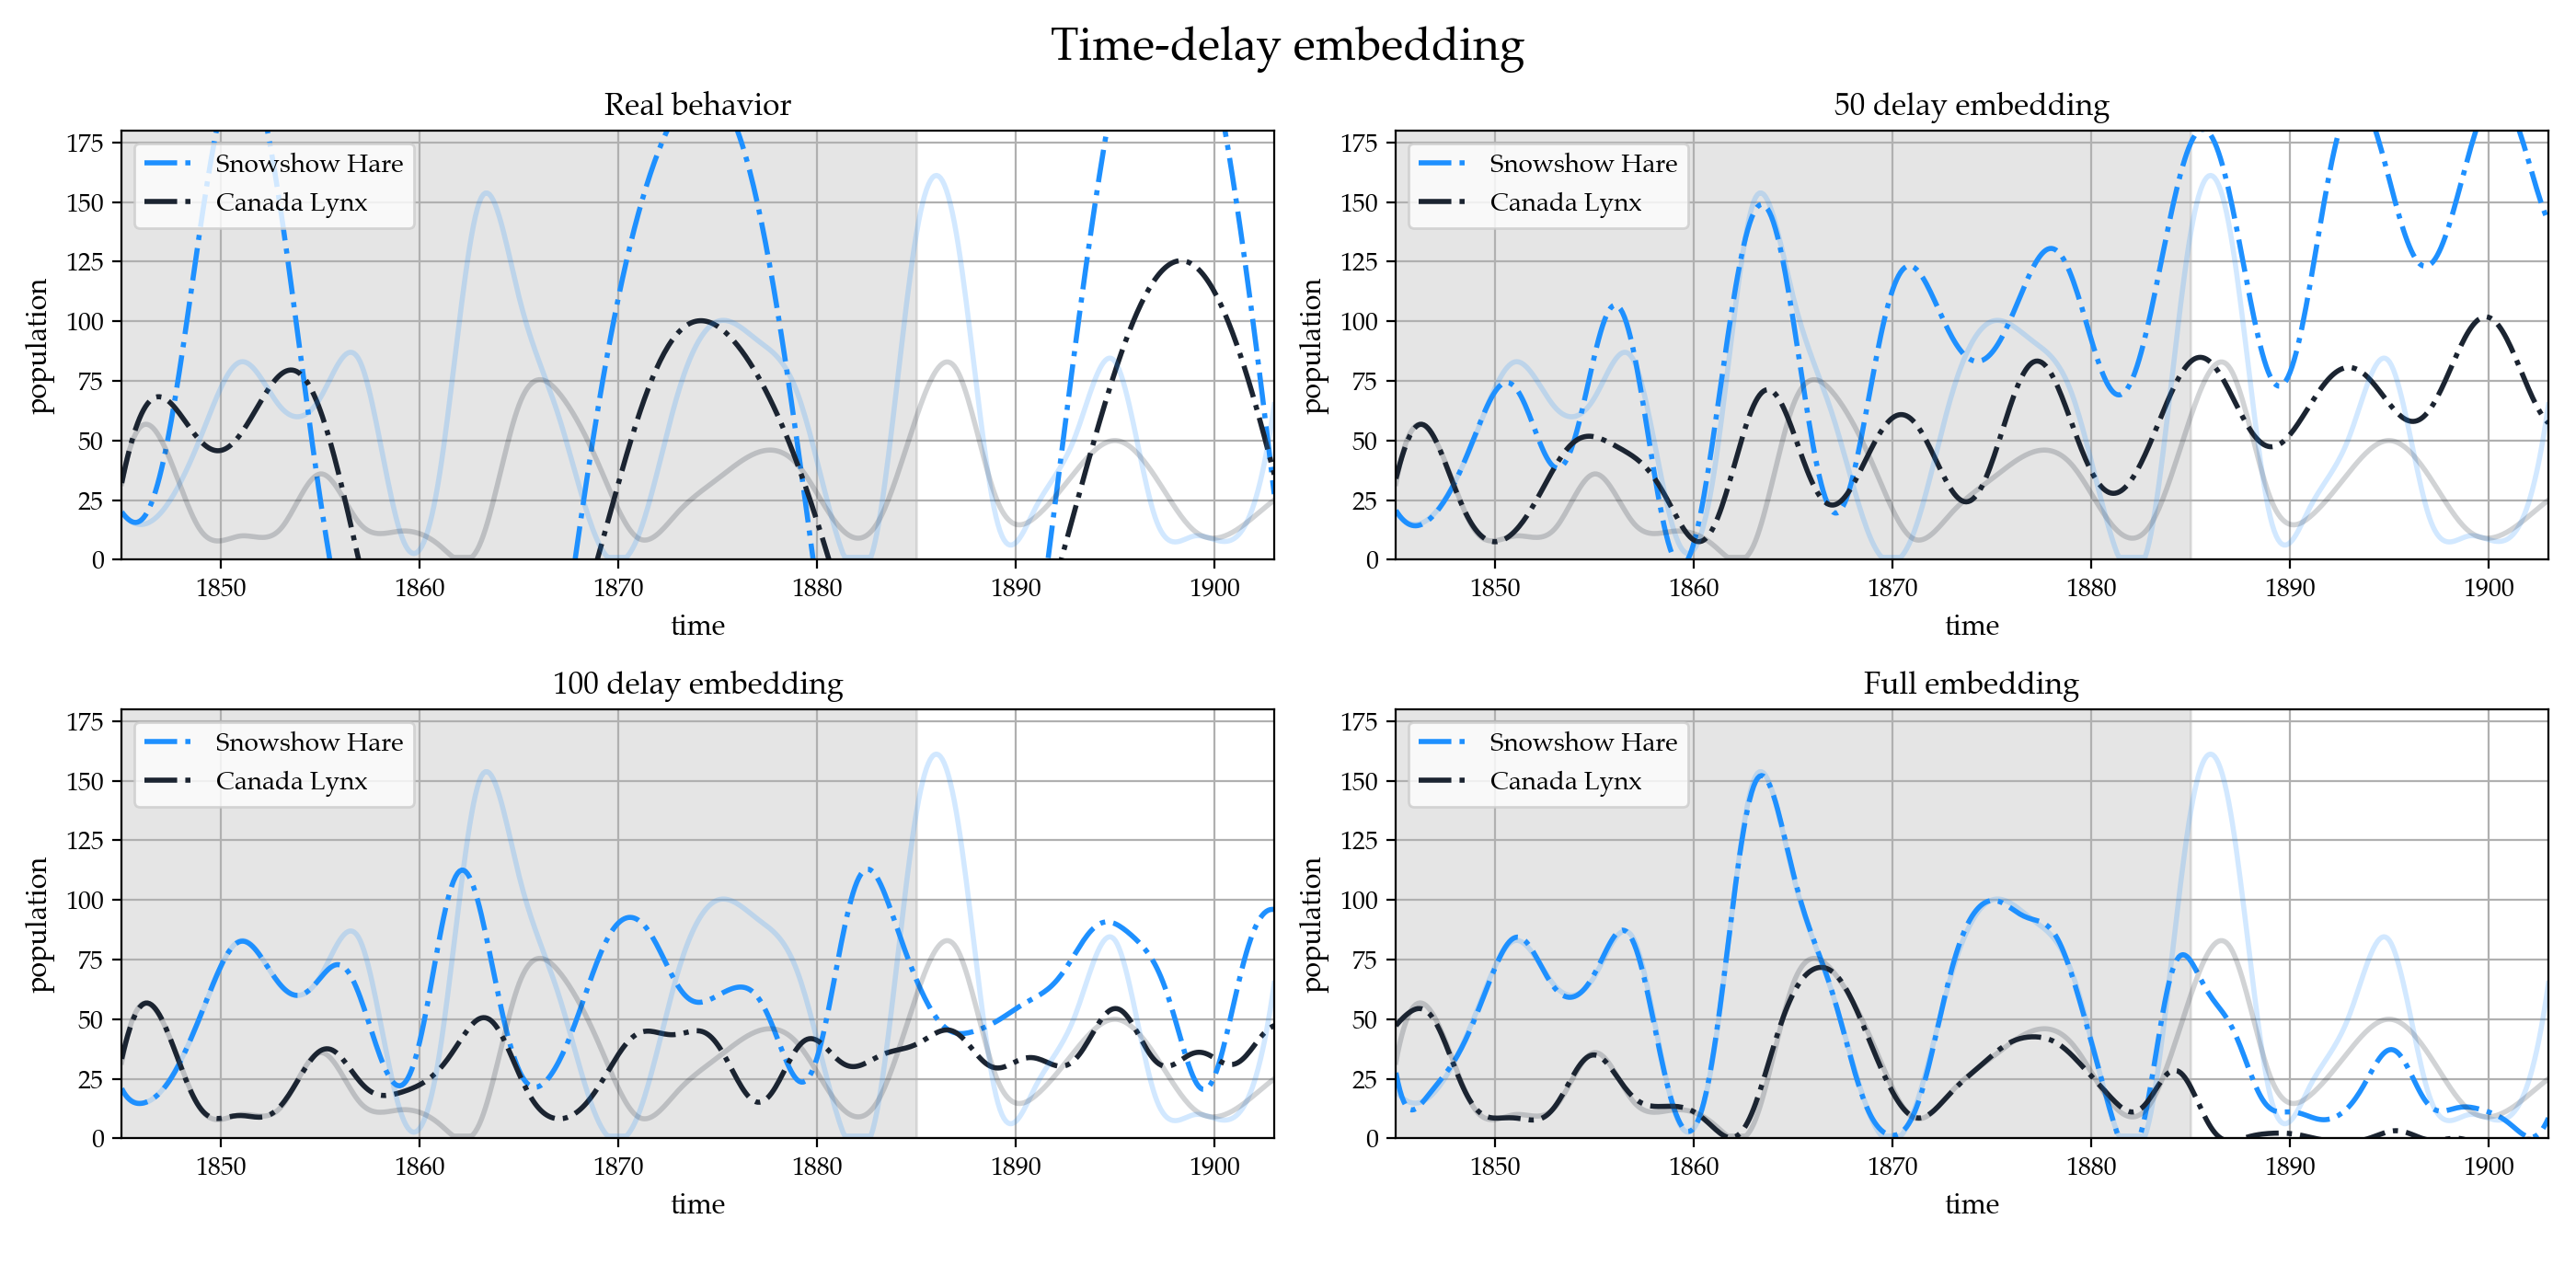

In [191]:
fig = plt.figure(figsize=(14, 7))
fig.suptitle("Time-delay embedding", fontsize=18)

gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(years_new[:], np.real(x_dmd1[0, :]), '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], np.real(x_dmd1[1, :]), '-.', linewidth='2', color='xkcd:dark')
h = ax.plot(years_new[:], data[0, :], linewidth='2', color='dodgerblue', alpha=0.2)
h = ax.plot(years_new[:], data[1, :], linewidth='2', color='xkcd:dark', alpha=0.2)
h = ax.fill([0, years_new[t_window], years_new[t_window], 0], [-100, -100, 200, 200], color='k', alpha=0.1) 
ax.set_ylim([0, 180])
ax.set_title('Real behavior', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('population', fontsize = 11)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 10, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(years_new[:], np.real(x_dmd2[0, :]), '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], np.real(x_dmd2[1, :]), '-.', linewidth='2', color='xkcd:dark')
h = ax.plot(years_new[:], data[0, :], linewidth='2', color='dodgerblue', alpha=0.2)
h = ax.plot(years_new[:], data[1, :], linewidth='2', color='xkcd:dark', alpha=0.2)
h = ax.fill([0, years_new[t_window], years_new[t_window], 0], [-100, -100, 200, 200], color='k', alpha=0.1)  
ax.set_ylim([0, 180])
ax.set_title('50 delay embedding', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('population', fontsize = 11)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 10, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

ax = plt.subplot(gs[1, 0])
h = ax.plot(years_new[:], np.real(x_dmd3[0, :]), '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], np.real(x_dmd3[1, :]), '-.', linewidth='2', color='xkcd:dark')
h = ax.plot(years_new[:], data[0, :], linewidth='2', color='dodgerblue', alpha=0.2)
h = ax.plot(years_new[:], data[1, :], linewidth='2', color='xkcd:dark', alpha=0.2)
h = ax.fill([0, years_new[t_window], years_new[t_window], 0], [-100, -100, 200, 200], color='k', alpha=0.1)  
ax.set_ylim([0, 180])
ax.set_title('100 delay embedding', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('population', fontsize = 11)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 10, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

ax = plt.subplot(gs[1, 1])
h = ax.plot(years_new[:], np.real(x_dmd4[0, :]), '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], np.real(x_dmd4[1, :]), '-.', linewidth='2', color='xkcd:dark')
h = ax.plot(years_new[:], data[0, :], linewidth='2', color='dodgerblue', alpha=0.2)
h = ax.plot(years_new[:], data[1, :], linewidth='2', color='xkcd:dark', alpha=0.2)
h = ax.fill([0, years_new[t_window], years_new[t_window], 0], [-100, -100, 200, 200], color='k', alpha=0.1)  
ax.set_ylim([0, 180])
ax.set_title('Full embedding', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('population', fontsize = 11)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 10, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])
#gs.tight_layout(fig)

fig.savefig('figures/td_dmd.pdf', format='pdf', dpi=1200)

## Part 3: Empirical Predator-Prey models such as Lotka-Volterra are commonly used to models such phenomenon. Consider the model x ̇ = (b − py)x and y ̇ = (rx − d)y. Use the data to fit values of b, p, r and d.

In [41]:
def rhs_lotkavolterra(t, x0, b, p, d, r):
    """Lotka_Volterra equations
    
        Parameters
    ----------
    t : array
        Discretization in time.
    x0 : array
        Initial conditions.
    b, p, d, r : float
        Positive parameters.

    Returns
    -------
    rhs : array
       Integration of the state.
    """
    x, y = x0
    rhs = [(b - p * y) * x ,
            (r * x - d) * y]
    return rhs

In [172]:
dt = dt_new
years = years_new
t = t_new
test_size = int(len(t) * 0.2)
x1 = SH_new[:-test_size]
x2 = CL_new[:-test_size]
x1_test = SH_new[-test_size:]
x2_test = CL_new[-test_size:]

Generation of state derivative vectors.

In [173]:
n = len(t) - test_size

noise = 0.

x1 = x1 + noise * np.random.randn(n,)
x2 = x2 + noise * np.random.randn(n,)

x1dot = [0] * (n - 2)
x2dot = [0] * (n - 2)

# center difference scheme
for i in range(1, n-1):
    x1dot[i-1] = (x1[i+1] - x1[i-1]) / (2 * dt)
    x2dot[i-1] = (x2[i+1] - x2[i-1]) / (2 * dt)
    
x1s = np.array(x1[1:-1])
x2s = np.array(x2[1:-1])

A1 = np.array([x1s, -x1s * x2s])
A2 = np.array([-x2s, x1s * x2s])

In [174]:
#model1 = Ridge(alpha=0.1, max_iter=1e5)
model1 = LinearRegression()
model1.fit(A1.T, x1dot)
#model2 = Ridge(alpha=0.1, max_iter=1e5)
model2 = LinearRegression()
model2.fit(A2.T, x2dot)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [175]:
load1 = np.linalg.pinv(A1.T) @ x1dot
load2 = np.linalg.pinv(A2.T )@ x2dot

<IPython.core.display.Javascript object>


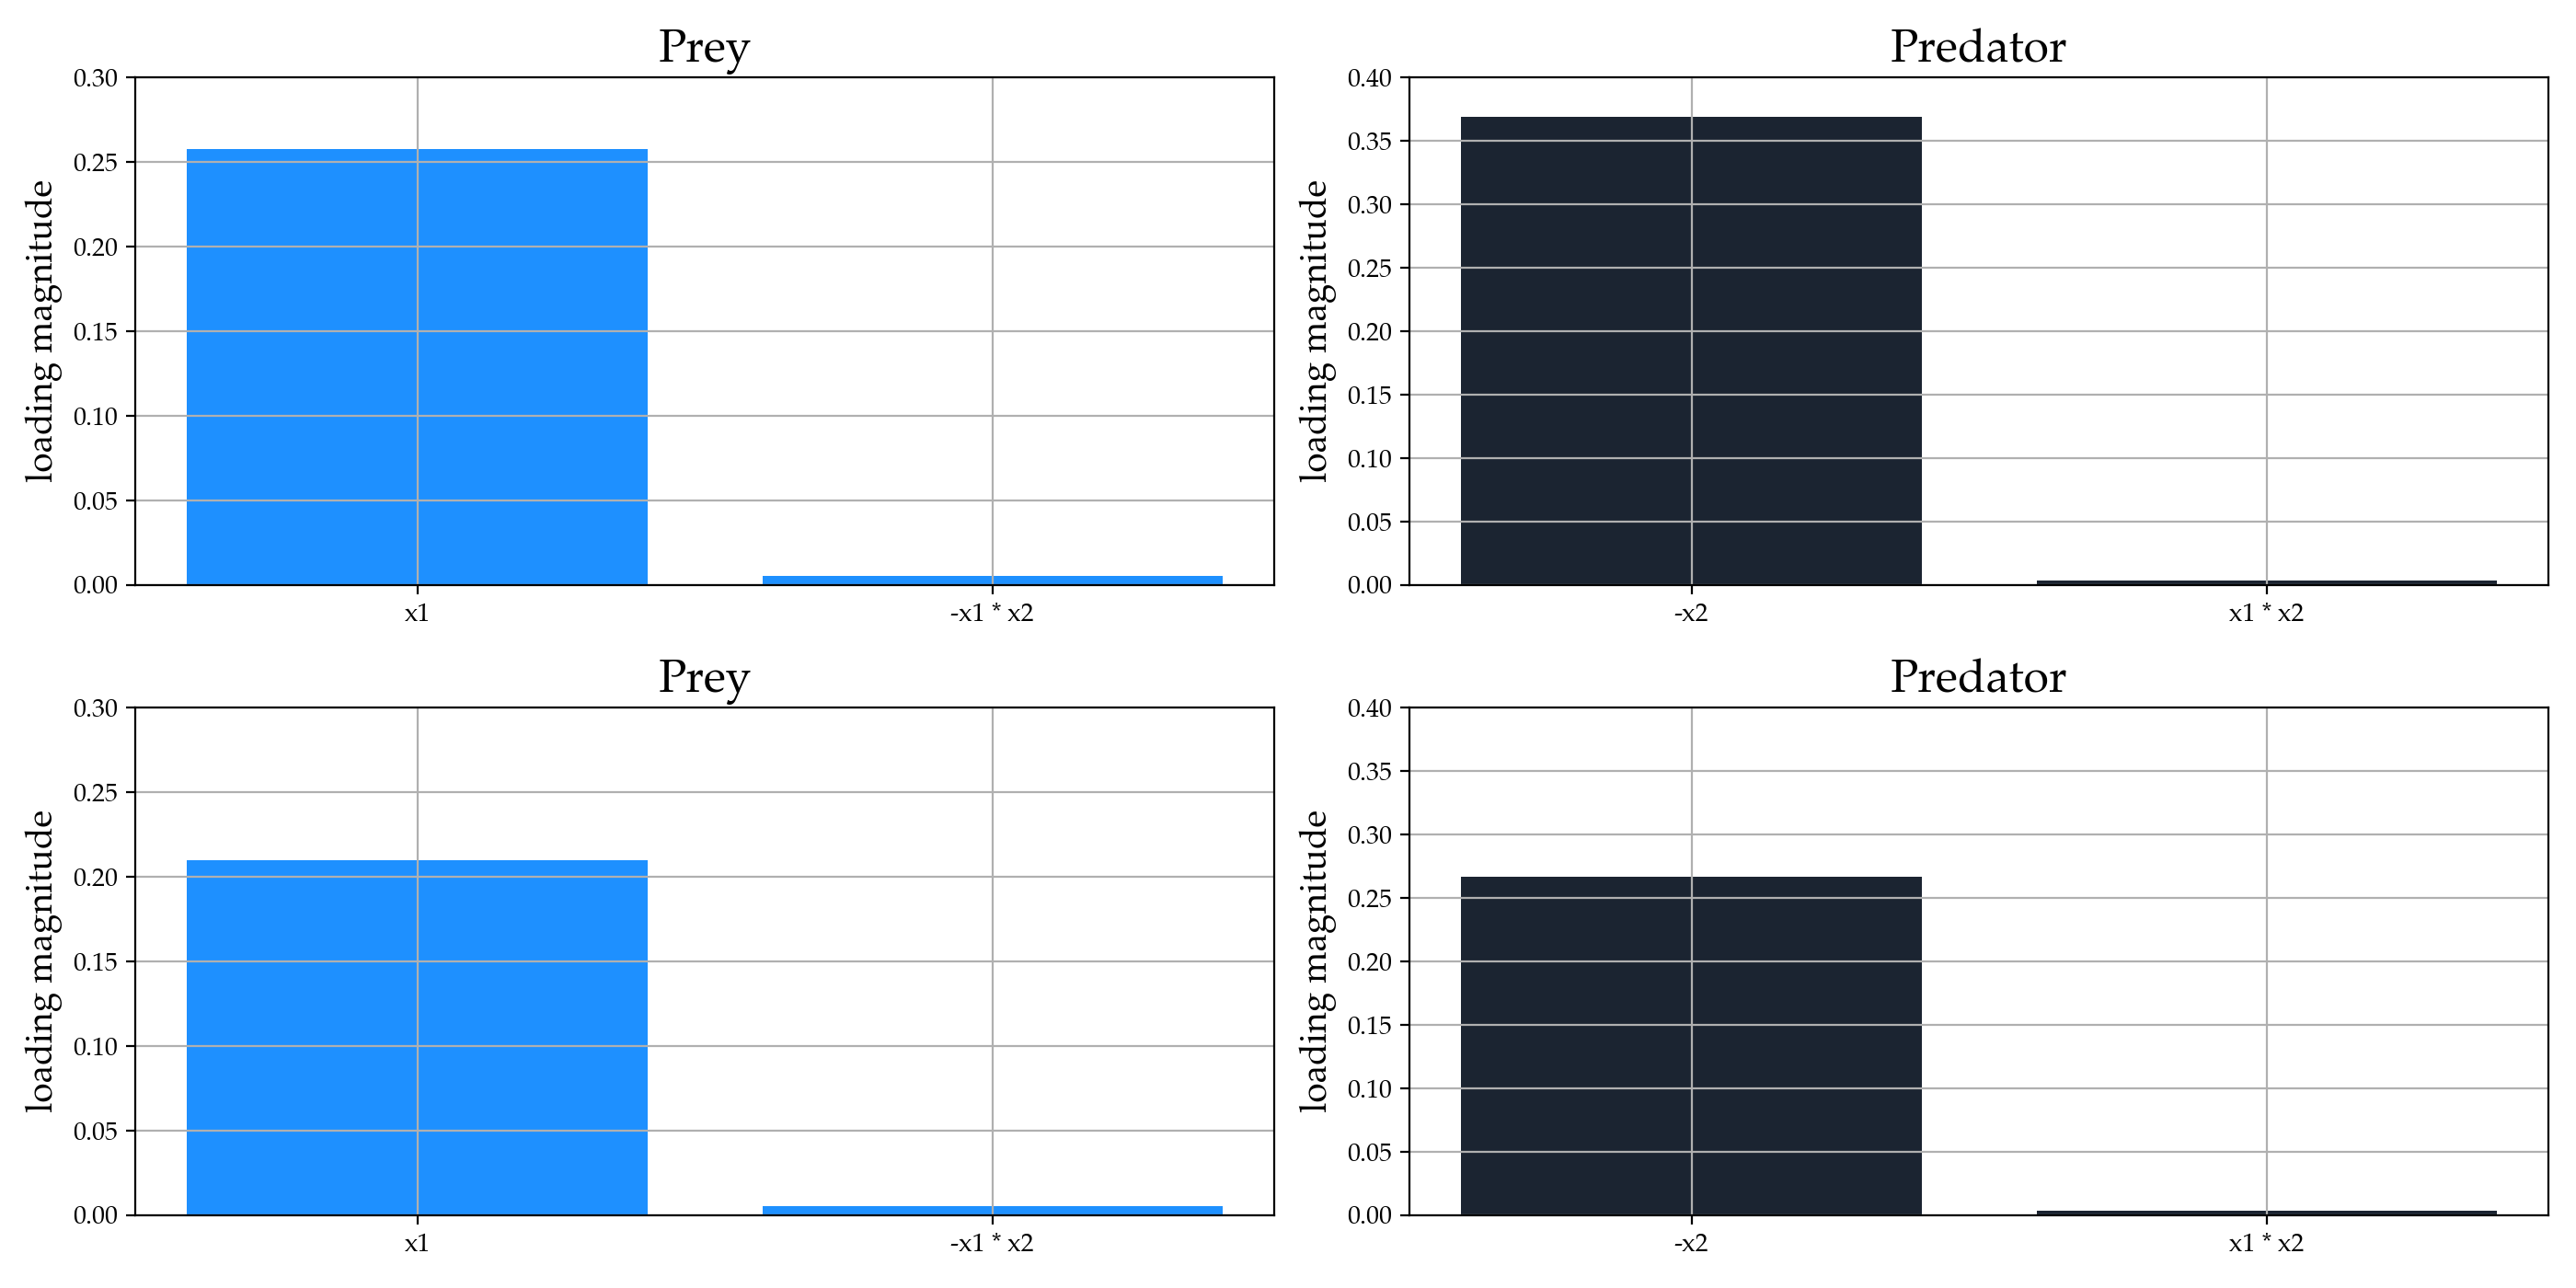

In [176]:
fig = plt.figure(figsize=(14, 7))
bar1_name = ['x1', '-x1 * x2']
bar2_name = ['-x2', 'x1 * x2']
gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.bar(bar1_name, model1.coef_, color='dodgerblue')
ax.set_title('Prey', fontsize = 18)
plt.ylabel('loading magnitude', fontsize = 14)
ax.set_ylim([0, 0.3])
plt.xticks(rotation=0)
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.bar(bar2_name, model2.coef_, color='xkcd:dark')
ax.set_title('Predator', fontsize = 18)
plt.ylabel('loading magnitude', fontsize = 14)
ax.set_ylim([0, 0.4])
plt.xticks(rotation=0)
ax.grid()

ax = plt.subplot(gs[1, 0])
h = ax.bar(bar1_name, load1, color='dodgerblue')
ax.set_title('Prey', fontsize = 18)
plt.ylabel('loading magnitude', fontsize = 14)
ax.set_ylim([0, 0.3])
plt.xticks(rotation=0)
ax.grid()

ax = plt.subplot(gs[1, 1])
h = ax.bar(bar2_name, load2, color='xkcd:dark')
ax.set_title('Predator', fontsize = 18)
plt.ylabel('loading magnitude', fontsize = 14)
ax.set_ylim([0, 0.4])
plt.xticks(rotation=0)
ax.grid()

gs.tight_layout(fig)
    
fig.savefig('figures/param_fit.pdf', format='pdf', dpi=1200)

Lotka-Volterra parameters estimate of regression with standard least square

In [48]:
b_l, p_l, d_l, r_l = model1.coef_[0], model1.coef_[1], model2.coef_[0], model2.coef_[1]
b_inv, p_inv, d_inv, r_inv = load1[0], load1[1], load2[0], load2[1]
print('- - - - -')
print('Lasso:')
print('- - - - -')
print("Estimate for b: {}".format(b_l))
print("Estimate for p: {}".format(p_l))
print("Estimate for d: {}".format(d_l))
print("Estimate for r: {}".format(r_l))
print('- - - - -')
print('\n')
print('- - - - -')
print('Pseudo inverse:')
print('- - - - -')
print("Estimate for b: {}".format(b_inv))
print("Estimate for p: {}".format(p_inv))
print("Estimate for d: {}".format(d_inv))
print("Estimate for r: {}".format(r_inv))
print('- - - - -')

- - - - -
Lasso:
- - - - -
Estimate for b: 0.2573590718289137
Estimate for p: 0.005363102105457593
Estimate for d: 0.36899578596748855
Estimate for r: 0.003456061376439866
- - - - -


- - - - -
Pseudo inverse:
- - - - -
Estimate for b: 0.20953768058097355
Estimate for p: 0.005140294836589593
Estimate for d: 0.2666325134585502
Estimate for r: 0.003089047140980951
- - - - -


Inegration os system dynamics fot the test times with estimate parameters 

In [184]:
x0 = [x1s[-1], x2s[-1]]
t_test = np.arange(t[-test_size], t[-1], 0.1)
sol_tmp = integrate.solve_ivp(rhs_lotkavolterra, [t[-test_size], t[-1]], x0, args=(b_inv, p_inv, d_inv, r_inv), method = 'RK45', t_eval=t_test)
sol = np.vstack((sol_tmp['y'][0], sol_tmp['y'][1])).T
#sol = integrate.odeint(rhs_lotkavolterra, x0, t_test, args=([], b, p, d, r), mxstep=10**8) # integrate PDE

<IPython.core.display.Javascript object>


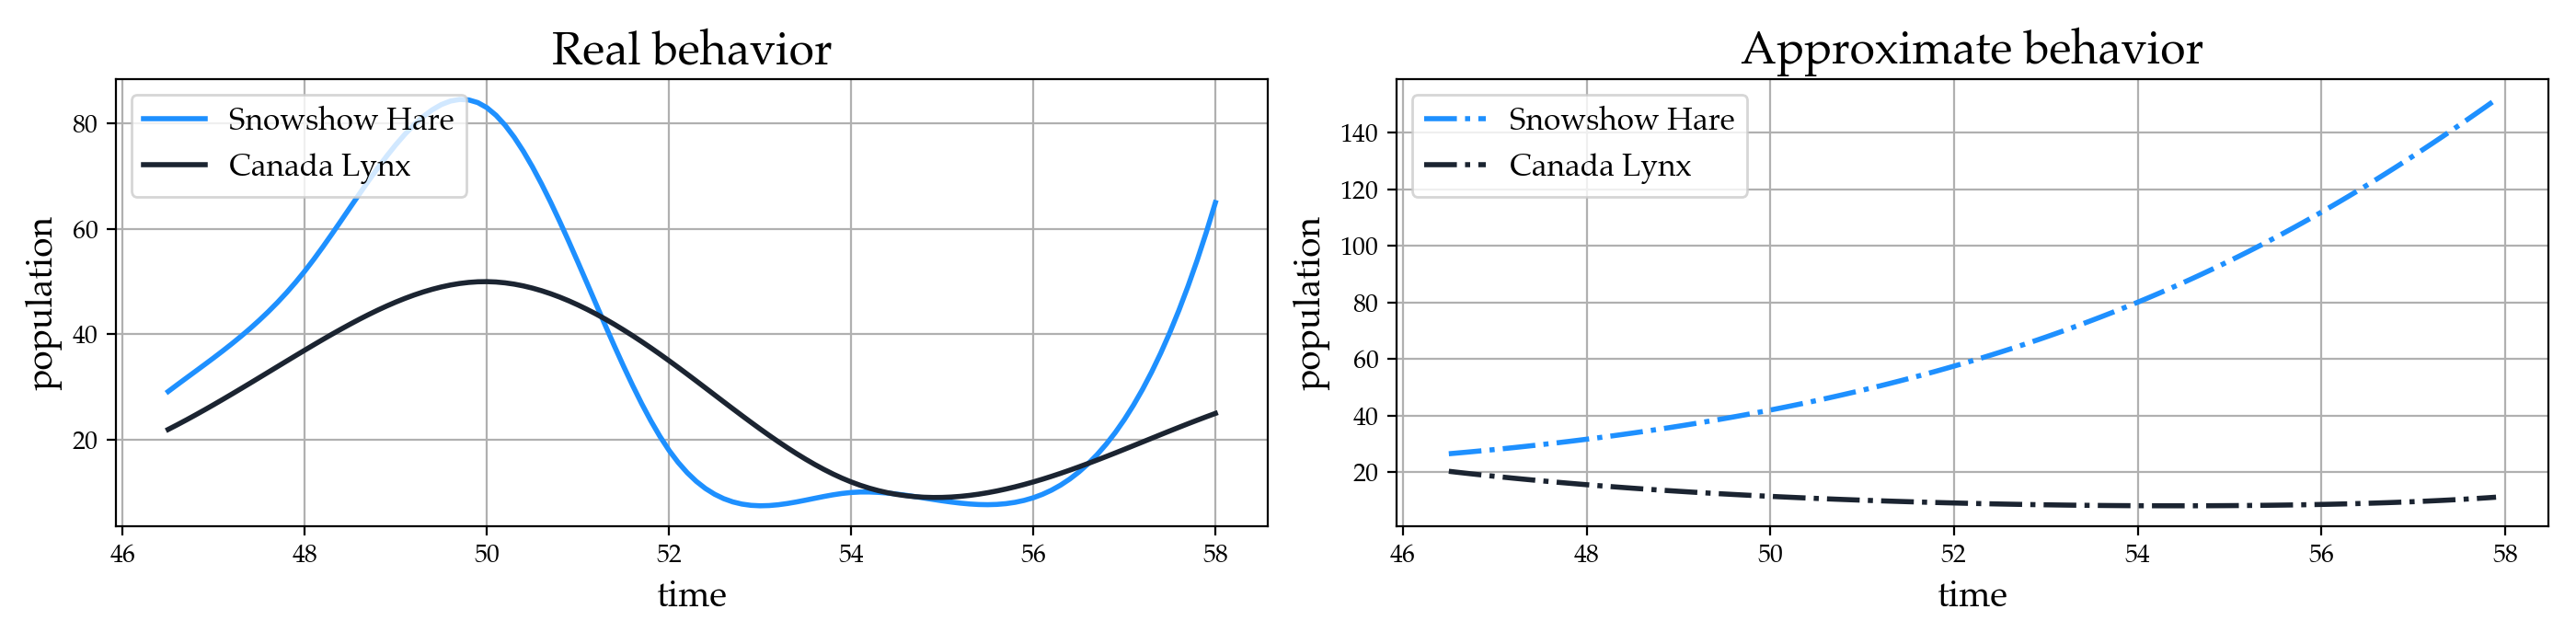

In [185]:
fig = plt.figure(figsize=(14, 3.5))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(t[-test_size:], x1_test, linewidth='2', color='dodgerblue')
h = ax.plot(t[-test_size:], x2_test, linewidth='2', color='xkcd:dark')
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(t_test, sol[:, 0], '-.', linewidth='2', color='dodgerblue')
h = ax.plot(t_test, sol[:, 1], '-.', linewidth='2', color='xkcd:dark')
ax.set_title('Approximate behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.grid()

gs.tight_layout(fig)

fig.savefig('figures/val_fit.pdf', format='pdf', dpi=1200)

Integration of the system dynamics along all the time axis

In [190]:
x0 = [x1[0], x2[0]]
t_test = np.arange(t[0], t[-1]+0.1, 0.1)
sol_tmp = integrate.solve_ivp(rhs_lotkavolterra, [t[0], t[-1]], x0, args=(b_inv, p_inv, d_inv, r_inv), method = 'RK45', t_eval=t_test)
sol = np.vstack((sol_tmp['y'][0], sol_tmp['y'][1])).T
x_true = np.vstack((SH_new, CL_new)).T
r2 = r2_score(x_true, sol)
print('- - - - -')
print('Alpha {}, R2 score: {}'.format(_alpha, r2))
print('- - - - -')

- - - - -
Alpha 10, R2 score: -2.8992107065065476
- - - - -


<IPython.core.display.Javascript object>


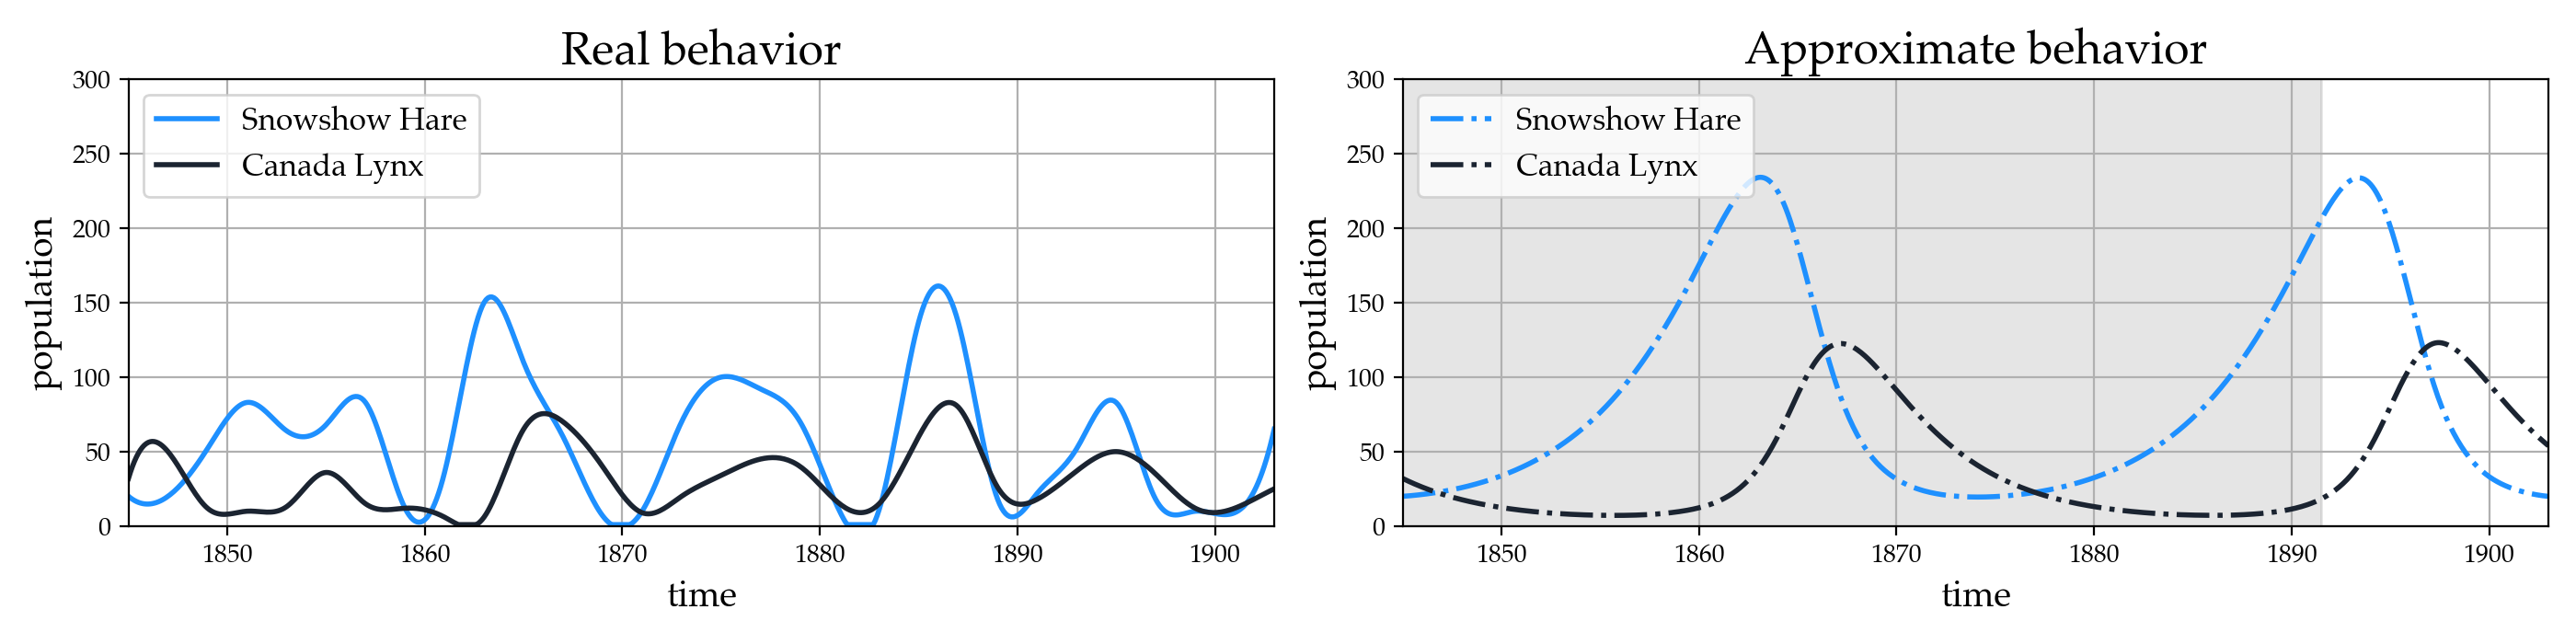

In [189]:
fig = plt.figure(figsize=(14, 3.5))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(years_new[:], SH_new, linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], CL_new, linewidth='2', color='xkcd:dark')
ax.set_ylim([0, 300])
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(years_new[:], sol[:, 0], '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], sol[:, 1], '-.', linewidth='2', color='xkcd:dark')
h = ax.fill([0, years_new[-test_size], years_new[-test_size], 0], [-100, -100, 500, 500], color='k', alpha=0.1)  
ax.set_ylim([0, 300])
ax.set_title('Approximate behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

gs.tight_layout(fig)

fig.savefig('figures/history_fit.pdf', format='pdf', dpi=1200)

## Part 4: Find the best fit nonlinear, dynamical systems model to the data using sparse regression

In [177]:
Library = {'x1' : lambda x: x[:, 0],
           'x2' : lambda x: x[:, 1],
           'x1^2' : lambda x: x[:, 0] ** 2,
           'x2^2' : lambda x: x[:, 1] ** 2,
           'x1*x2' : lambda x: x[:, 0] * x[:, 1],
           'x1^3' : lambda x: x[:, 0] ** 3,
           'x2^3' : lambda x: x[:, 1] ** 3,
           'x1^2*x2' : lambda x: x[:, 0] ** 2 * x[:, 1],
           'x2^2*x1' : lambda x: x[:, 1] ** 2 * x[:, 0],
           '1/x1' :  lambda x: 1 / x[:, 0],
           '1/x2' : lambda x: 1 / x[:, 1],
           '1/x1^2' : lambda x: 1 / (x[:, 0] ** 2),
           '1/x2^2' : lambda x: 1 / (x[:, 1] ** 2),
           '1/(x1*x2)' : lambda x: 1 / (x[:, 0] * x[:, 1]),
           '1/x1^3' : lambda x: 1 / (x[:, 0] ** 3),
           '1/x2^3' : lambda x: 1 / (x[:, 1] ** 3),
           '1/(x1^2*x2)' : lambda x: 1 / (x[:, 0] ** 2 * x[:, 1]),
           '1/(x2^2*x1)' : lambda x: 1 / (x[:, 1] ** 2 * x[:, 0]),
           'cos(x1)' : lambda x: np.cos(x[:, 0]),
           'cos(x2)' : lambda x: np.cos(x[:, 1]),
           'sin(x1)' : lambda x: np.sin(x[:, 0]),
           'sin(x2)' : lambda x: np.sin(x[:, 1]),
          }

In [178]:
x = np.vstack((x1s, x2s)).T
for exp in Library.keys():
    Theta = Library[exp](x) if exp == 'x1' else np.vstack((Theta, Library[exp](x)))
Theta = Theta.T

In [179]:
from sklearn.metrics import r2_score
alpha = [0.0001, 0.001, 0.005, 0.1, 1, 10, 20]

for _alpha in alpha:
    sindy1 = Lasso(alpha=_alpha, max_iter=1e7)
    sindy1.fit(Theta, x1dot)
    sindy2 = Lasso(alpha=_alpha, max_iter=1e7)
    sindy2.fit(Theta, x2dot)
    x_pred = x[None, 0, :] # avoid removing a dimension
    dt = t[1] - t[0]
    for i in range(1, len(t)):
        exp_feat = np.array([Library[exp](x_pred[None, i-1, :]) for exp in Library.keys()])
        dx1_tmp = sindy1.predict(exp_feat.T) * dt + x_pred[None, i-1, 0]
        dx2_tmp = sindy2.predict(exp_feat.T) * dt + x_pred[None, i-1, 1]
        dx_tmp = np.array([dx1_tmp, dx2_tmp]).T
        x_pred = np.vstack((x_pred, dx_tmp))
    r2 = r2_score(x_true, x_pred)
    print('- - - - -')
    print('Alpha {}, R2 score: {}'.format(_alpha, r2))
    print('- - - - -')
    print('\n')

- - - - -
Alpha 0.0001, R2 score: -0.9232781851924167
- - - - -


- - - - -
Alpha 0.001, R2 score: -0.032477075801691624
- - - - -


- - - - -
Alpha 0.005, R2 score: 0.007690078719345572
- - - - -


- - - - -
Alpha 0.1, R2 score: -0.16119086771176527
- - - - -


- - - - -
Alpha 1, R2 score: -0.3838476753081915
- - - - -




/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in square
  if __name__ == '__main__':
/opt/anaconda3/lib/

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [180]:
sindy1 = Lasso(alpha=0.005, max_iter=1e7)
sindy1.fit(Theta, x1dot)
sindy2 = Lasso(alpha=0.005, max_iter=1e7)
sindy2.fit(Theta, x2dot)
x_pred = x[None, 0, :] # avoid removing a dimension
dt = t[1] - t[0]
for i in range(1, len(t)):
    exp_feat = np.array([Library[exp](x_pred[None, i-1, :]) for exp in Library.keys()])
    dx1_tmp = sindy1.predict(exp_feat.T) * dt + x_pred[None, i-1, 0]
    dx2_tmp = sindy2.predict(exp_feat.T) * dt + x_pred[None, i-1, 1]
    dx_tmp = np.array([dx1_tmp, dx2_tmp]).T
    x_pred = np.vstack((x_pred, dx_tmp))

<IPython.core.display.Javascript object>


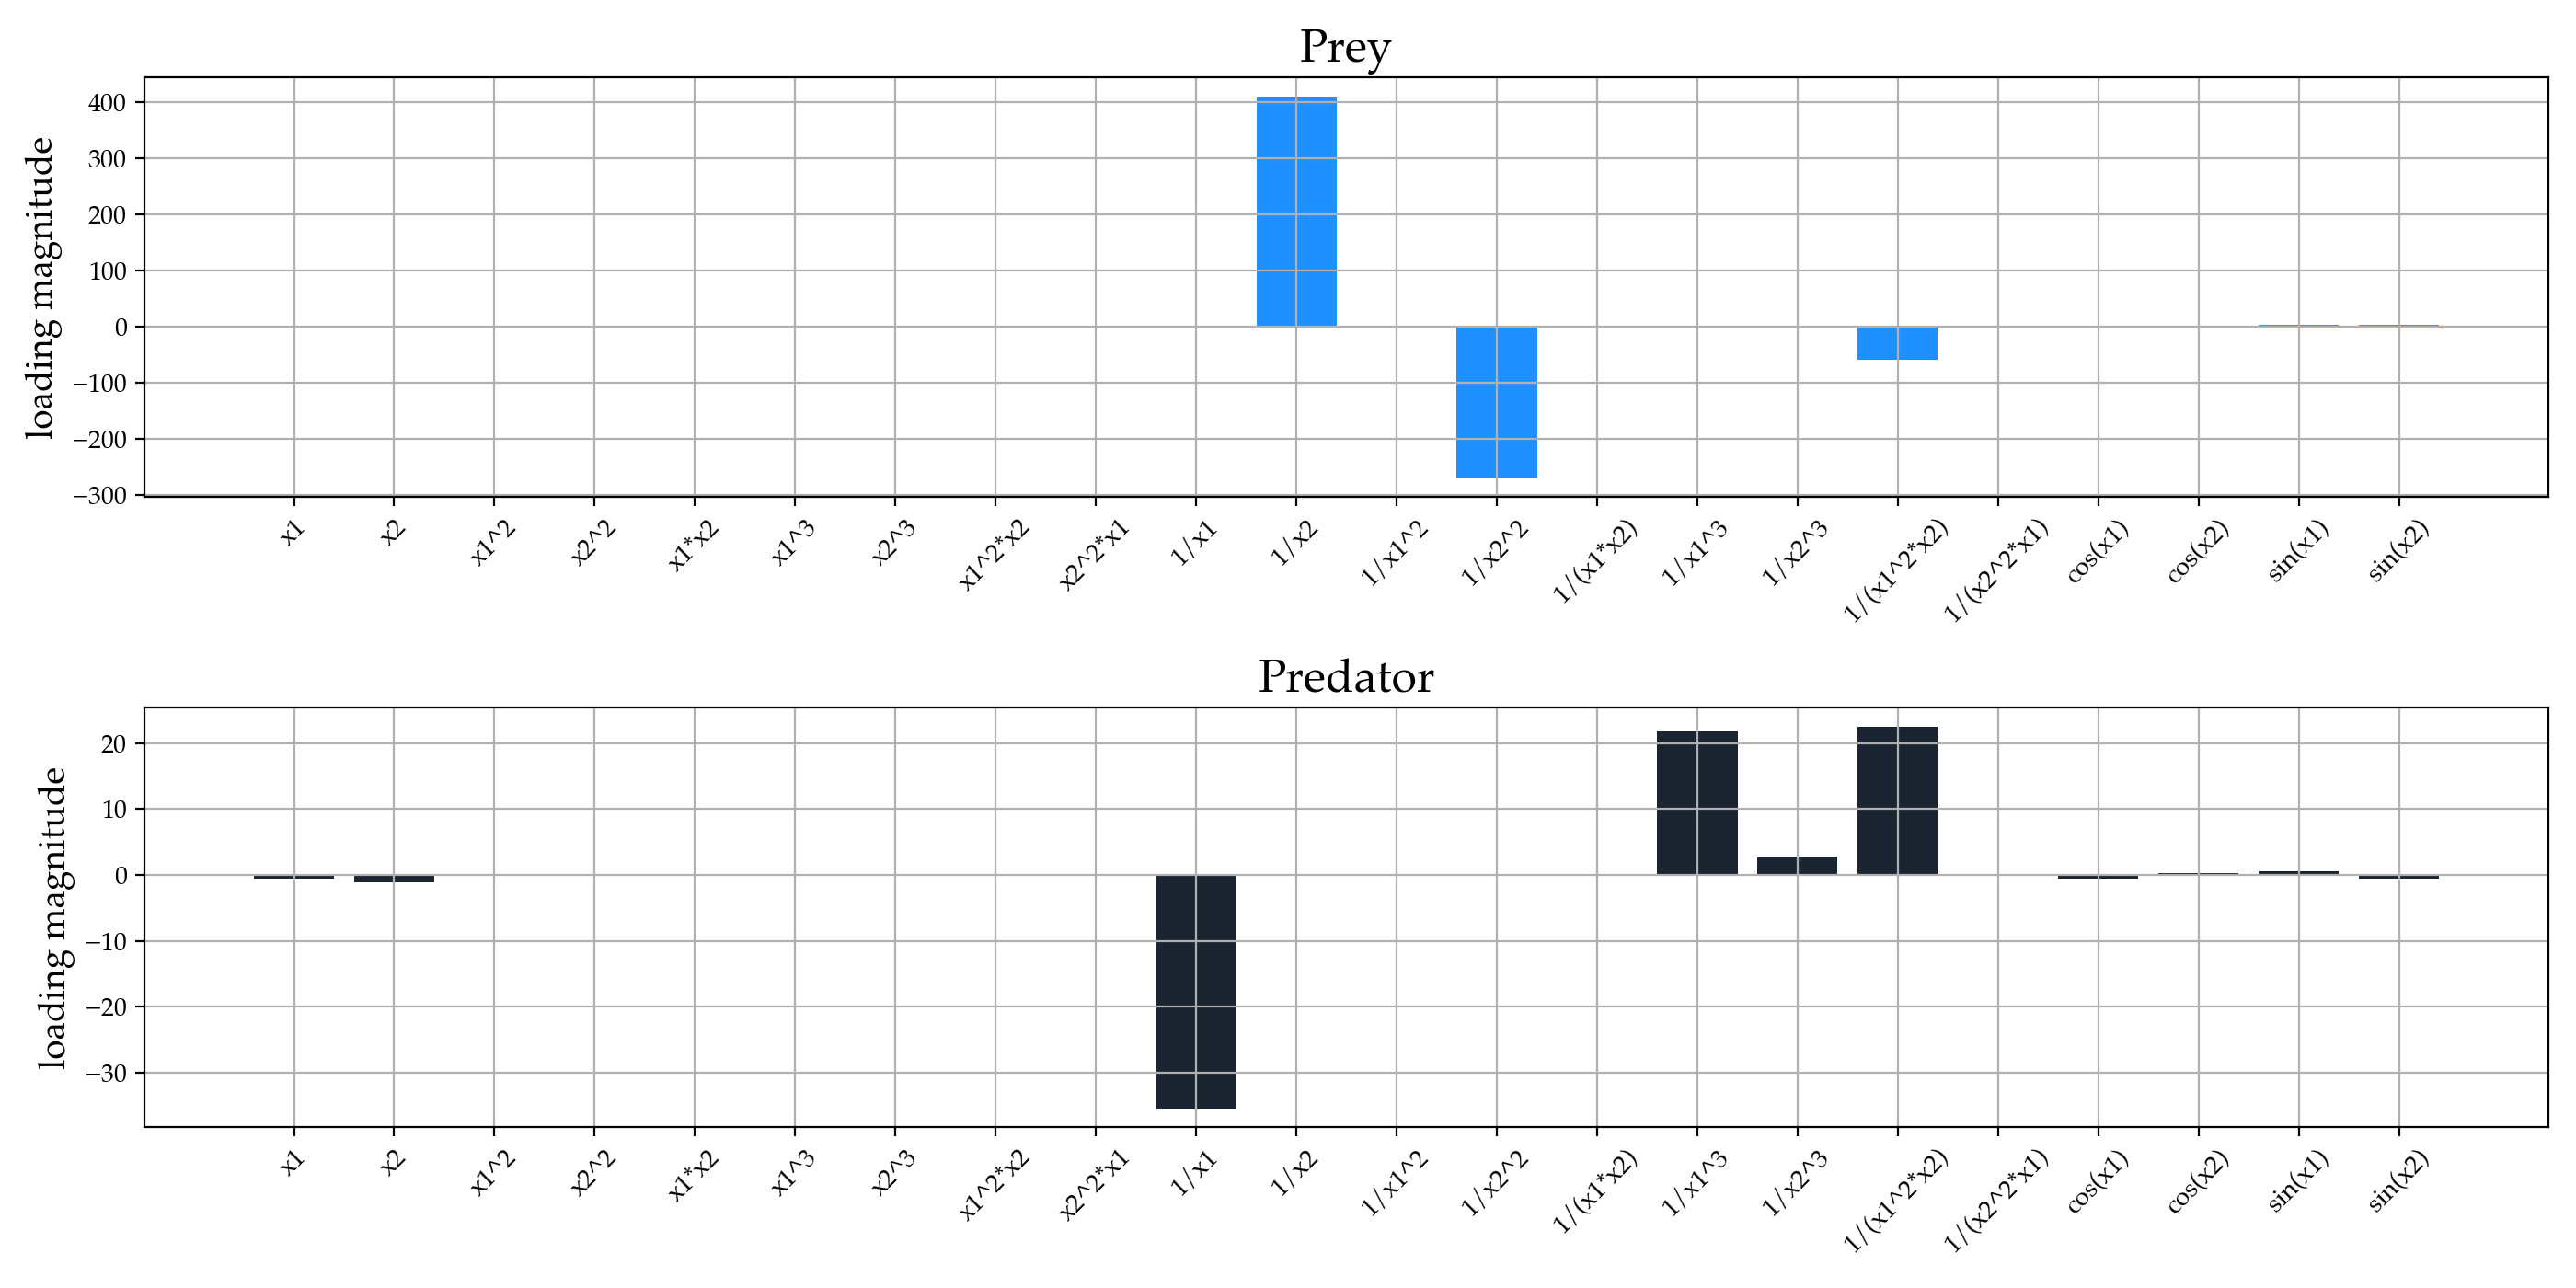

In [181]:
fig = plt.figure(figsize=(14, 7))
bar_name = [key for key in Library.keys()]
gs = gridspec.GridSpec(2, 1)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.bar(bar_name, sindy1.coef_, color='dodgerblue')
ax.set_title('Prey', fontsize = 18)
plt.ylabel('loading magnitude', fontsize = 14)
plt.xticks(rotation=45)
ax.grid()

ax = plt.subplot(gs[1, 0])
h = ax.bar(bar_name, sindy2.coef_, color='xkcd:dark')
ax.set_title('Predator', fontsize = 18)
plt.ylabel('loading magnitude', fontsize = 14)
plt.xticks(rotation=45)
ax.grid()

gs.tight_layout(fig)
    
fig.savefig('figures/nl_param_fit.pdf', format='pdf', dpi=1200)

<IPython.core.display.Javascript object>


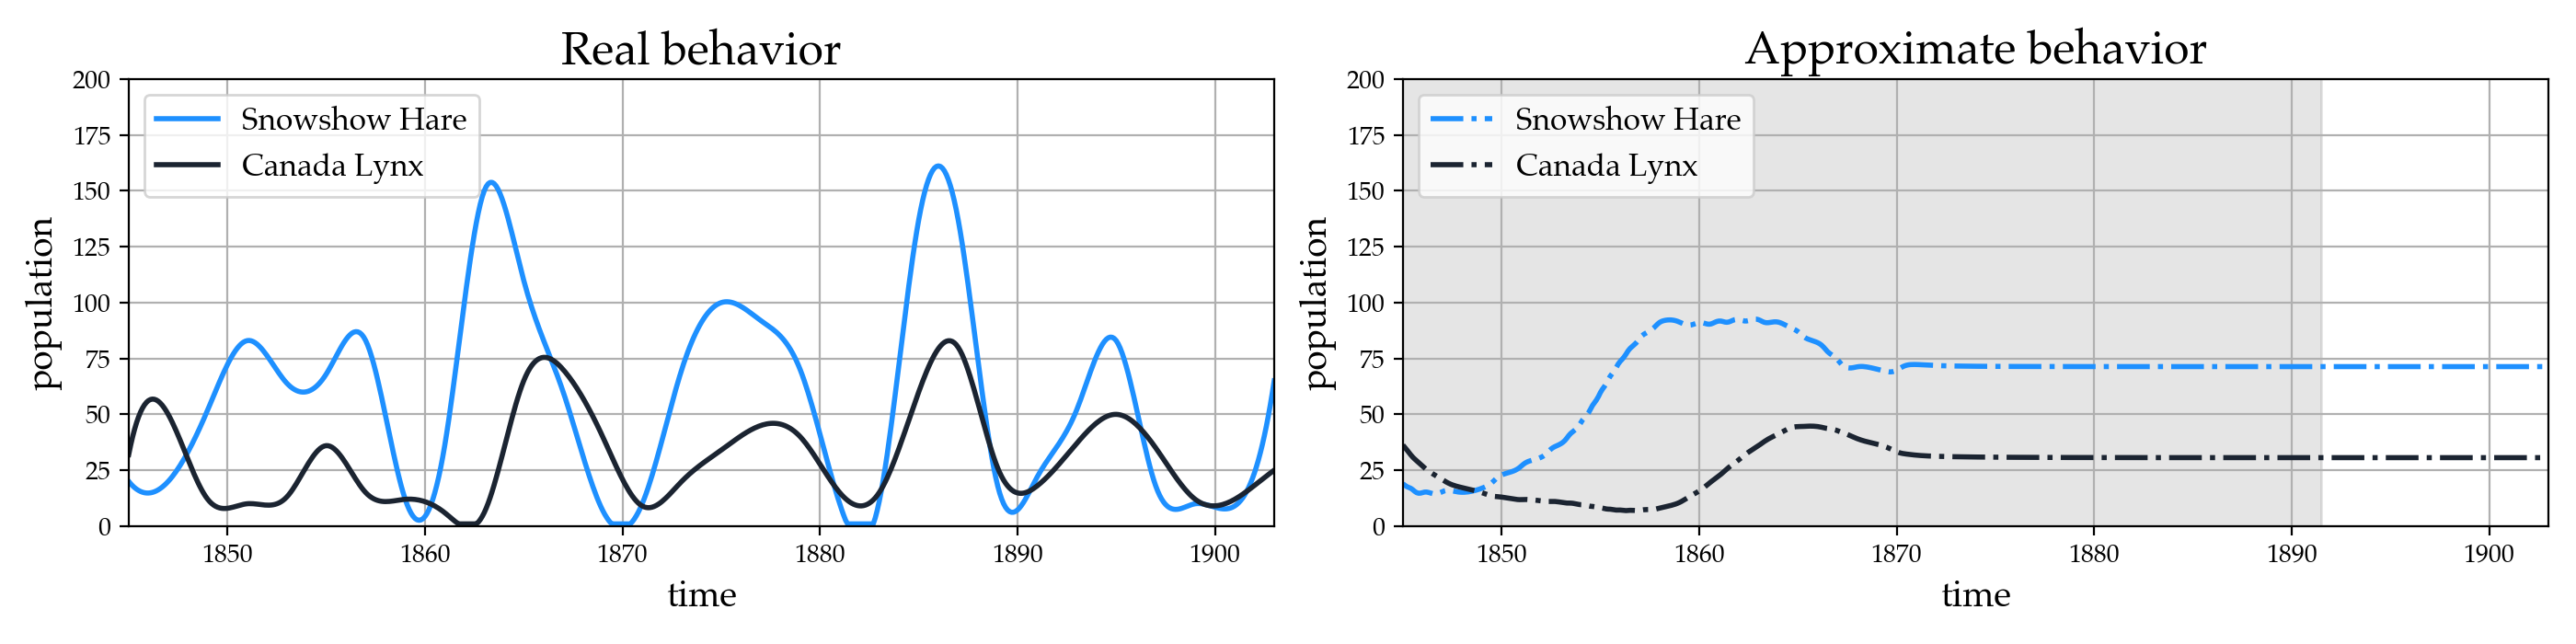

In [182]:
fig = plt.figure(figsize=(14, 3.5))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(years_new[:], SH_new, linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], CL_new, linewidth='2', color='xkcd:dark')
ax.set_ylim([0, 200])
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(years_new[:], x_pred[:, 0], '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], x_pred[:, 1], '-.', linewidth='2', color='xkcd:dark')
h = ax.fill([0, years_new[-test_size], years_new[-test_size], 0], [-100, -100, 500, 500], color='k', alpha=0.1)  
ax.set_ylim([0, 200])
ax.set_title('Approximate behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

gs.tight_layout(fig)

fig.savefig('figures/nl_history_fit.pdf', format='pdf', dpi=1200)

---
DEPRECATED CODES
---

In [232]:
def rhs_best_fit_nds(t, x0, xi1, xi2):
    x0 = np.reshape(x0,(1, -1))
    x = feature_expansion(x0)
    y = feature_expansion(x0)
    dx = 0
    dy = 0
    for i in range(x.shape[1]):
        if xi1[i] > 1e-3:
            dx += x[0,i] * xi1[i]
        if xi2[i] > 1e-3:
            dy += y[0,i] * xi2[i]
    #dx = x @ xi1
    #dy = y @ xi2
    rhs = np.hstack((dx, dy))
    return rhs

In [154]:
x0 = x[0, :]
xi1 = np.reshape(sindy1.coef_,(-1,1))
xi2 = np.reshape(sindy2.coef_,(-1,1))
sol_tmp = integrate.solve_ivp(rhs_best_fit_nds, [t[0], t[-1]], x0, args=(xi1, xi2), method='RK45', t_eval=t)
sol = np.vstack((sol_tmp['y'][0], sol_tmp['y'][1])).T

<IPython.core.display.Javascript object>


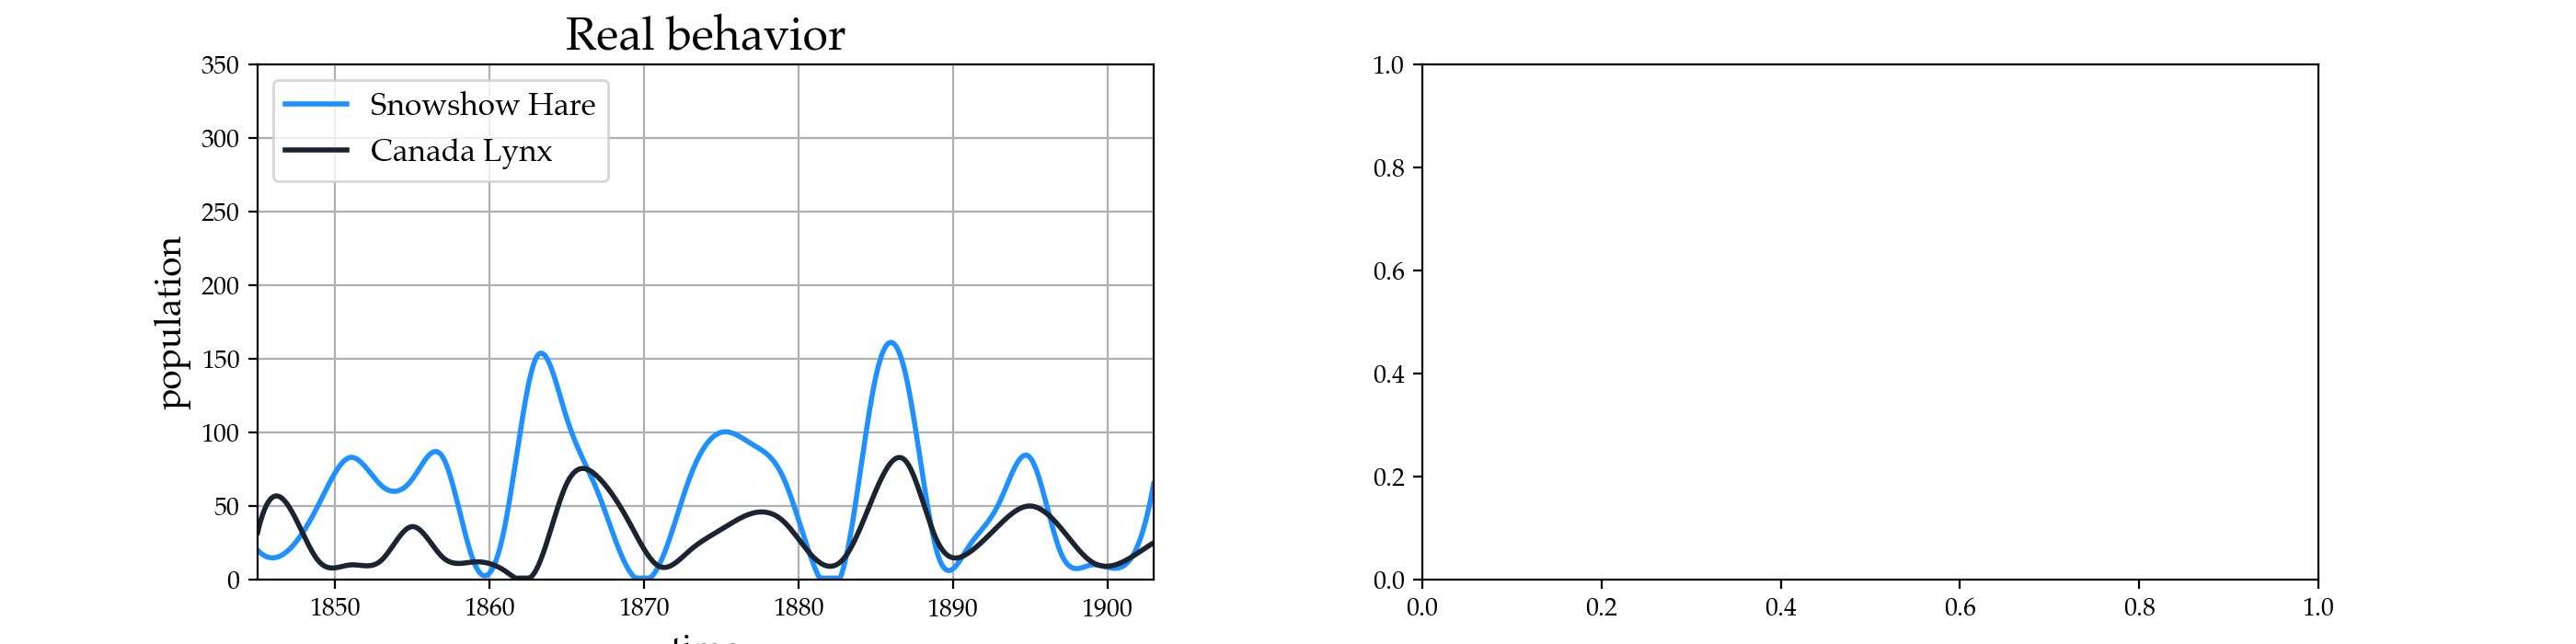

ValueError: x and y must have same first dimension, but have shapes (581,) and (580,)

In [587]:
fig = plt.figure(figsize=(14, 3.5))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(years_new[:], SH_new, linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], CL_new, linewidth='2', color='xkcd:dark')
ax.set_ylim([0, 350])
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(years_new[:], sol[:, 0], '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], sol[:, 1], '-.', linewidth='2', color='xkcd:dark')
h = ax.fill([0, years_new[-test_size], years_new[-test_size], 0], [-100, -100, 500, 500], color='k', alpha=0.1)  
ax.set_ylim([0, 350])
ax.set_title('Approximate behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

gs.tight_layout(fig)

#fig.savefig('figures/history_fit.pdf', format='pdf', dpi=1200)

In [97]:
alpha = [0.001, 0.1, 1, 10, 20]

sindy1 = Lasso(alpha=0.1, max_iter=1e5)
sindy1.fit(Theta, x1dot)
sindy2 = Lasso(alpha=0.1, max_iter=1e5)
sindy2.fit(Theta, x2dot)
x_pred = x[0, :]
x_pred = np.reshape(x_pred, (1, -1))
dt = t[1] - t[0]
for i in range(1, len(t)):
    exp_feat = feature_expansion(np.reshape(x_pred[i-1, :], (1, -1)))
    dx1_tmp = sindy1.predict(exp_feat) * dt + x_pred[i-1, 0]
    dx2_tmp = sindy2.predict(exp_feat) * dt + x_pred[i-1, 1]
    dx_tmp = np.array([dx1_tmp, dx2_tmp]).T
    x_pred = np.vstack((x_pred, dx_tmp))

ValueError: shapes (1,18) and (23,) not aligned: 18 (dim 1) != 23 (dim 0)

In [53]:
x = np.vstack((x1s, x2s)).T
polynomial3 = PolynomialFeatures(degree=3, include_bias=False)
polynomial2 = PolynomialFeatures(degree=2, include_bias=False)
polynomial1 = PolynomialFeatures(degree=1, include_bias=False)
x_poly = np.hstack((polynomial3.fit_transform(x), 1 / polynomial2.fit_transform(x)))
x_trig = np.hstack((np.cos(x), np.sin(x)))

def feature_expansion(x):
    return np.hstack((polynomial3.fit_transform(x), 1 /  polynomial2.fit_transform(x), np.cos(x), np.sin(x)))
    #return polynomial3.fit_transform(x)
    
Theta = np.hstack((x_poly, x_trig))
#Theta = x_poly